# Introduction

*** 

This notebook runs all the analysis and figures for Wood et al., 2021: "A reliable, efficient method to assess static lower limb proprioception using a Bayesian adaptive algorithm."

The essentials are:
1. Plotting all individual data for Test 1 and Test 2. One of the individuals was used for Figure 1C of the paper 
2. Run the Bayesian analysis from the paper:
    * Movement direction analysis with a Bayesian logistic regression. Including the figure used in Figure 1D for the paper
    * Bland-Altman analysis using a Bayesian estaimtion of bias and a Bayesian regression 
    * Regression analysis for Test 1 vs Test 2 using a Bayesian regression 
    * For each of the Bayesian analyses, I:
        1. Define and describe the model and the equations 
        2. Define the priors and plot samples from the prior 
        3. Plot the trace for model diagnostics 
        4. Define and justify the ROPE
        5. Analyze and plot the posteriors 
3. Plot Figure 2 from the paper 
4. Calculcates the agreement measures for threshold and slope after 75 and 50 trials and puts them in a table
5. Run some analyses that are in the discussion

***

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import os
import glob
import pandas as pd
import arviz as az
import pymc as pm
from scipy.special import expit as logistic
import pingouin as pg
from tabulate import tabulate
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
#Plotting parameters
plt.rcParams.update({'font.size': 18})

#Plot colors 
color_t1 = '#ca0020'
color_t2 = '#0571b0'
color_a = '#7b3294'
color_b = '#008837'
color_bottom = 'k'
color_top = 'gray'

#Set figure path and extension
fig_path = '/Users/jonathanwood/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofDelaware-o365/Team-CHS-PT-Morton Lab - Split-Belt Recal - Jonathan - Split-Belt Recal - Jonathan/Docs/Writing/Test_Retest paper/Figures'
extension = '.eps'

#Random sampling for the prior
RANDOM_SEED = 61
num_samples = 1000

## Define functions

In [3]:
def UniqueVals(stims, responses):
    
    """
    Definition: Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

def bayes_logisitic_regression(y_data, x1, x2, x3, prior):
    
    """
    Definition: Runs the bayesian logisitic regression model
    
    Inputs:
    y_data = outcome variable
    x1, x2, x3 = predictor variables, should be the same shape as the outcome variable
    prior = list or array of size 2 - each item is a prior parameter for each predictor variable, 
    all variables will have the same prior: a normal distribution with the mean as the first item and the SD as the second item
    
    
    Outputs:
    trace = Inference data object that contains the samples
    prior_samples = samples for the prior distribution 
    """
        
    N = len(np.unique(x1))
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000
    
    #Build model using PM 
    with pm.Model() as Model:
        alpha = pm.Normal("alpha", mu=prior[0], sigma=prior[1], shape=N)
        B_movdir = pm.Normal("B_movdir", mu=prior[0], sigma=prior[1], shape=2)
        B_stims = pm.Normal("B_stims", mu=prior[0], sigma=prior[1])
        p = pm.Deterministic("p", pm.math.invlogit(alpha[x1] +
                                                   B_movdir[x2] + 
                                                   B_stims * x3))
        response = pm.Binomial("response", 1, p, observed=y_data)
        prior_samples = pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
        
    return trace, prior_samples

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

def bayes_simple_regression(y_data, x_data, intercept_prior, slope_prior):
        
    """
    Definition: Runs the bayesian simple regression model
    
    Inputs:
    y_data = outcome variable
    x_data = predictor variable, should be the same shape as the outcome variable
    intercept_prior = the prior for the intercept parameter; list or array of size 2 - first item is mean, second is SD
    slope_prior  = the prior for the slope parameter; list or array of size 2 - first item is mean, second is SD
    
    
    Outputs:
    trace = Inference data object that contains the samples
    prior_samples = samples for the prior distribution
    """
        
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000

    #Calculate the posterior
    with pm.Model() as model:
        intercept = pm.Normal("intercept", mu=intercept_prior[0], sigma=intercept_prior[1])
        slope = pm.Normal("slope", mu=slope_prior[0], sigma=slope_prior[1])
        sigma = pm.Exponential("sigma", 0.05)
        mu = pm.Deterministic("mu", intercept + slope*x_data)
        y = pm.Normal("y",mu=mu, sigma=sigma, observed=y_data)
        prior_samples = pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
    
    return trace, prior_samples

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

def bayes_onesamp_ttest(data, prior):
    
    """
    Definition: Compares the data to 0
    
    Inputs:
    data = difference data
    prior = the prior parameter for the difference distribution; list or array of size 2 - first item is mean, second is SD
    
    
    Outputs:
    trace = Inference data object that contains the samples
    prior_samples = samples for the prior distribution
    """
        
    #Random sampling
    RANDOM_SEED = 61
    num_samples = 1000
    
    #Calculate the posterior
    with pm.Model() as Model:
        mu = pm.Normal("mu", mu=prior[0], sigma=prior[1])
        sigma = pm.Exponential("sigma", 0.05)
        y = pm.Normal("y",mu=mu, sigma=sigma, observed=data)
        prior_samples= pm.sample_prior_predictive(samples=num_samples, random_seed=RANDOM_SEED)
        trace = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
    
    return prior_samples, trace

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

def calc_response_prob(movement_direction, responses):
    
    """
    Definition: Calcualtes the probability of responses based on movement direction

    Inputs:
    movement_direction = an array of movement directions 1 = backwards to the stim postiion, 0 = forwards
    responses = an array of the response data for each movement direction
    
    Outputs:
    P_left_back = probability of responding left when the movement direction was backward
    P_left_fwd = probability of responding left when the movement direction was forward
    """
    
    responses_back = responses[movement_direction == 1]
    responses_fwd = responses[movement_direction == 0]
    
    P_left_back = sum(responses_back)/sum(movement_direction==1)
    P_left_fwd = sum(responses_fwd)/sum(movement_direction==0)
    
    return P_left_back, P_left_fwd

#-------------------------------------------------------------------------
#-------------------------------------------------------------------------

def plot_individual_afc(alphas, betas, stims, responses, ax):
    
    """
    Definition: plots individual data on an axis 

    Inputs:
    alphas = pair of one individual's alphas for Test 1 and Test 2
    betas = pair of one individual's betas for Test 1 and Test 2
    stims = array of stimulus values, each test is a column, each row is a trial
    responses = array of responses, each test is a column, each row is a trial (1='left', 0='right')
    ax = axis object on which to plot

    Outputs:
    plots axis object
    """
    
    #Set color for plotting
    color_t1 = '#ca0020'
    color_t2 = '#0571b0'

    x = np.arange(-100,101)
    psi_1 = norm.cdf(x,alphas[0],betas[0])
    psi_2 = norm.cdf(x,alphas[1],betas[1])
    
    #Index the actual stimulus values
    x_1, Nstims_1, Kleft_1 = UniqueVals(stims[:,0], responses[:,0])
    x_2, Nstims_2, Kleft_2 = UniqueVals(stims[:,1], responses[:,1])

    #Plot
    ax.plot(np.arange(-100,1),np.ones(101)*0.5,'k--')
    ax.plot(np.zeros(50),np.linspace(0,0.5),'k--')
    
    #Test 1
    ax.plot(x, psi_1, c=color_t1, lw=2)
    ax.plot(x_1, Kleft_1/Nstims_1, 'o', c=color_t1, alpha=0.5)
    ax.text(-100,0.9,'Test 1', c=color_t1)
    ax.text(-100, 0.8, r'$\alpha=$' + str(round(alphas[0]))
            + r' $\beta=$' + str(round(betas[0])), c=color_t1)

    #Test 2
    ax.plot(x, psi_2, c=color_t2, lw=2)
    ax.plot(x_2, Kleft_2/Nstims_2, 'o', c=color_t2, alpha=0.5)
    ax.text(-100,0.7,'Test 2', c=color_t2)
    ax.text(-100,0.6, r'$\alpha=$' + str(round(alphas[1]))
           + r' $\beta=$' + str(round(betas[1])), c=color_t2)
    ax.set(ylabel='probability left more forward', xlabel='Stimuli (left - right)', title=name)
    

## Load data

In [4]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Split-Belt-AFC-Reliability/Data/TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

N = len(np.unique(DF.SID))
#Print the subjects
print('N =', N)

N = 13


## Retrieve estimates and plot individual data

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_57310/1966435865.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_57310/1966435865.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(7, 2, subj_name_idx + 1)


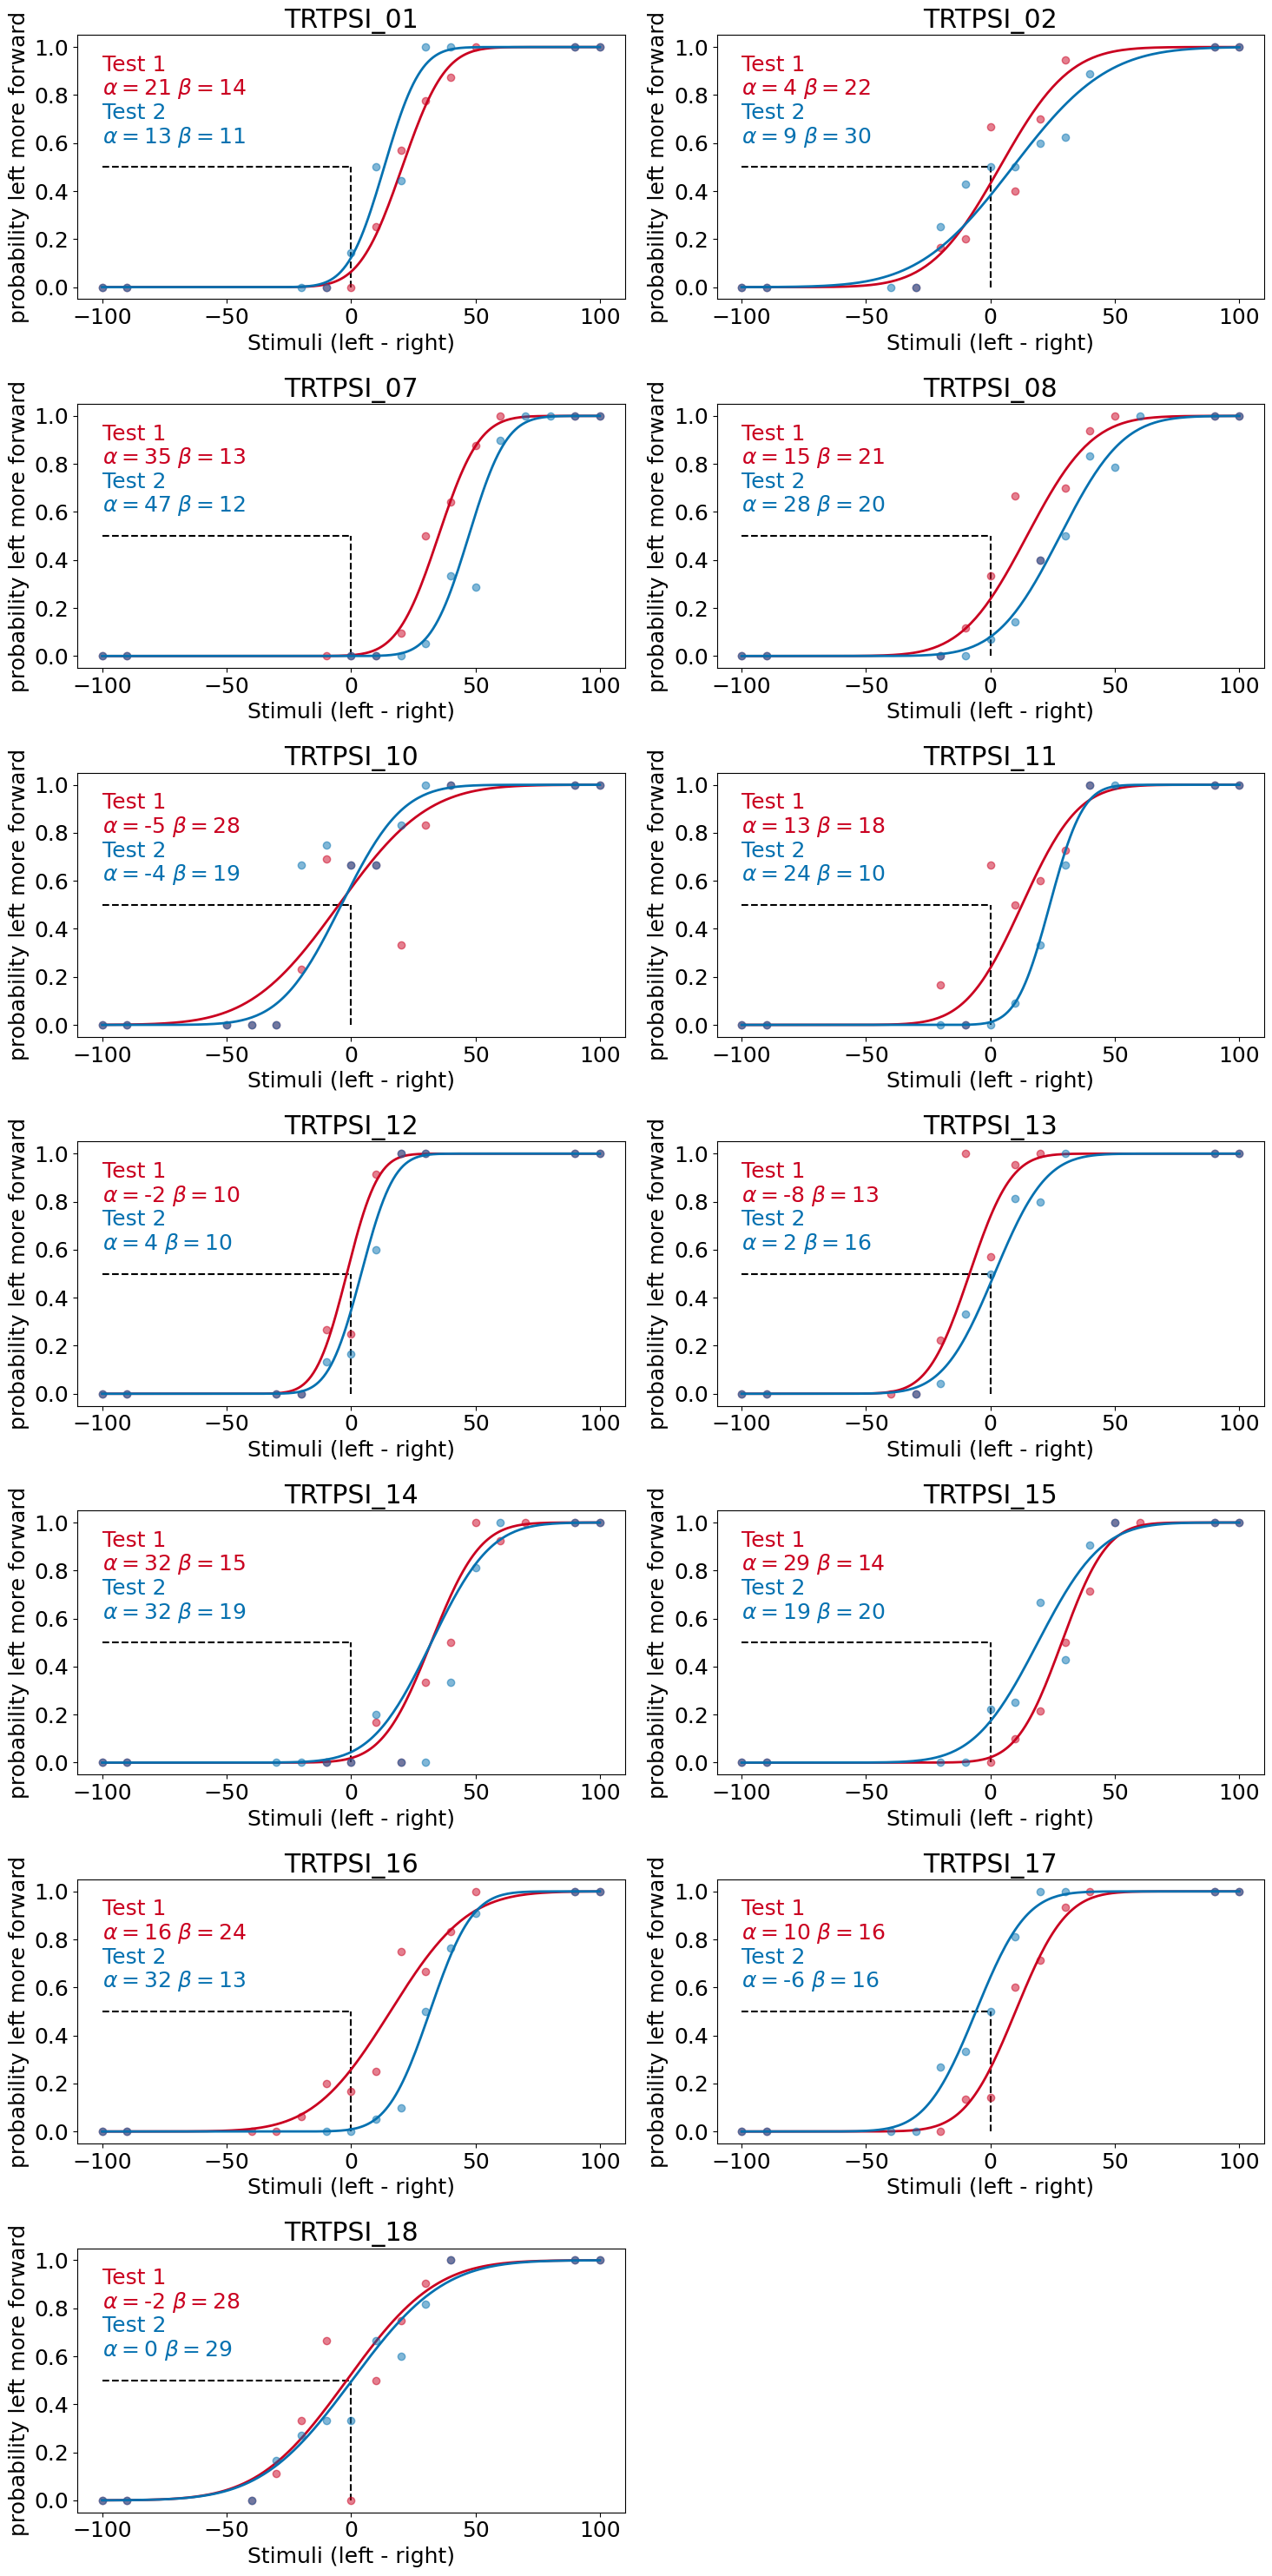

In [5]:
unique_tests = ['a','b']

plt.subplots(figsize=(15,30), tight_layout=True)

#Extract the final estimates of the alpha and beta values
alphas, betas = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    
    stims, responses = np.empty((75,2)), np.empty((75,2))
    for test_id_idx, test_id in enumerate(unique_tests):

        #Index data
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        betas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[-1]
        
        stims[:, test_id_idx] = test[test.Test==test_id].AllStims.values+BslDiff
        responses[:, test_id_idx] = test[test.Test==test_id].BinaryResponses.values
       
    #Plot
    ax = plt.subplot(7, 2, subj_name_idx + 1)
    plot_individual_afc(alphas[subj_name_idx, :], 
                        betas[subj_name_idx, :], 
                        stims, responses, ax) 


## Descriptive Stats

In [6]:
#Alphas
print('All Alphas = ' + str(round(np.mean(alphas))) + ' +/- ' + str(round(np.std(alphas))))
print('Test 1 Alphas = ' + str(round(np.mean(alphas[:,0]))) + ' +/- ' + str(round(np.std(alphas[:,0]))))
print('Test 2 Alphas = ' + str(round(np.mean(alphas[:,1]))) + ' +/- ' + str(round(np.std(alphas[:,1]))))

All Alphas = 14 +/- 15
Test 1 Alphas = 12 +/- 14
Test 2 Alphas = 15 +/- 16


In [7]:
#Betas
print('All Betas = ' + str(round(np.mean(betas))) + ' +/- ' + str(round(np.std(betas))))
print('Test 1 Betas = ' + str(round(np.mean(betas[:,0]))) + ' +/- ' + str(round(np.std(betas[:,0]))))
print('Test 2 Betas = ' + str(round(np.mean(betas[:,1]))) + ' +/- ' + str(round(np.std(betas[:,1]))))

All Betas = 18 +/- 6
Test 1 Betas = 18 +/- 6
Test 2 Betas = 17 +/- 6


In [8]:
#Means
alpha_mean = np.mean(alphas,axis=1)
beta_mean = np.mean(betas,axis=1)

#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]

print('Mean alpha difference = ' + str(round(np.mean(alpha_diff))) + ' +/- ' + str(round(np.std(alpha_diff))))
print('Mean beta difference = ' + str(round(np.mean(beta_diff))) + ' +/- ' + str(round(np.std(beta_diff))))

Mean alpha difference = -3 +/- 9
Mean beta difference = 1 +/- 5


# Impact of movement direction

First we use a logistiic regression to determine the impact of movement direction on participants decisions

## Define the model

We used a Bayesian logistic regression to determine the individual impact that moving backward and forward had on the probability of responding ‘left’. Since the response data were binary, we modeled them as a Binomial distribution where the probability of responding “left” ($p_{left}$) was impacted by the stimulus location $(X_{stimulus}$), the movement direction ($X_{move direction}$), and the participant ($X_{participant}$):

$$ Response \approx Binomial(p_{left}) $$
$$ logit(p_{left}) = \alpha_{participant}[X_{participant}] + \beta_{move direction}[X_{move direction}] + \beta_{stimulus} X_{stimulus}$$
$$ \alpha_{participant} \approx Normal(0,1) $$
$$ \beta_{move direction} \approx Normal(0,1) $$
$$ \beta_{stimulus} \approx Normal(0,1) $$

**Define the priors:**

For this model, I do not have different prior assumptions for a value for each parameter so I set them as the same. In other words, I have no reason to beleive any of these variables are going to impact the probability of responding left more than another. Ill just center them all around 0.5 probability with a normal distribution N(0,1). This one is pretty uninformative in probability space. 

I also tried different priors to ensure that they did not impact the overall results:
* mu=0, sigma=0.5. This is tighter in probability space. This doesnt really change the results at all. 
* mu=0, sigma=0.1, this is a really tight disitribution in probability space around 0.5, this changes the posteriors but not the overall results.  
Now for wider priors, the wider they get the more they actually favor the extremes of the probability distribution (high concentrations around 0 and 1)
* mu=0, sigma=5, this really widens the uncertainty, but does not change the results
* mu=0, sigma=2 is pretty much uniform in probability space. Does not change the results

**Variables:**
* Response = 1='left', 0='right'
* $X_{move direction}$ = movement direction (1=backwards, 0=forwards)
* X_{stimulus} = stimulus positions (continuous) 
* X_{participant} = indexing variable for each subject

**Rope justification:**

If movement directions were completely unbiased, 19 of the 38 backward movements would be "left" responses and 17-18 of the 37 forward movements would be "right" responses. For practical purposes, plus or minus 2 responses should be equalivant to no bias for each movement direction. If we assume the backward movements are more biased for left and the forwards movements are more biased for right, 2 responses in terms of probability equates to 0.55 for the backwards movement and 0.43. This means a difference in probability between -0.12 to 0.12 should be considered equivilant. Here I tighten the range a bit to -0.1 to 0.1 being practically equivilant.

In terms of log-odds, this equates to -2.2 to 2.2.

In [9]:
# Set the variables
y = np.array(DF.BinaryResponses,dtype=int) #Binary responses (1=left, 0=right)
x_move_dir = np.array(DF.AllStarts.values > DF.AllStims.values, dtype=int) # 1 for backwards to the stim postiion, 0 for forwards
x_stims = [DF.AllStims.values[i] + np.round(DF.BslDiff.values[i])  for i in range(len(DF.AllStims.values))]
x_stims = np.array(x_stims)
x_SID = [np.ones(150, dtype=int)*int(i) for i in range(len(np.unique(DF.SID)))]
x_SID = np.concatenate(x_SID)

## Calculcate the posterior

In [10]:
trace_logistic, prior_samples_logistic = bayes_logisitic_regression(y_data=y, x1=x_SID, x2=x_move_dir, x3=x_stims, prior=[0,1])

Sampling: [B_movdir, B_stims, alpha, response]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, B_movdir, B_stims]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 59 seconds.


## Model checks

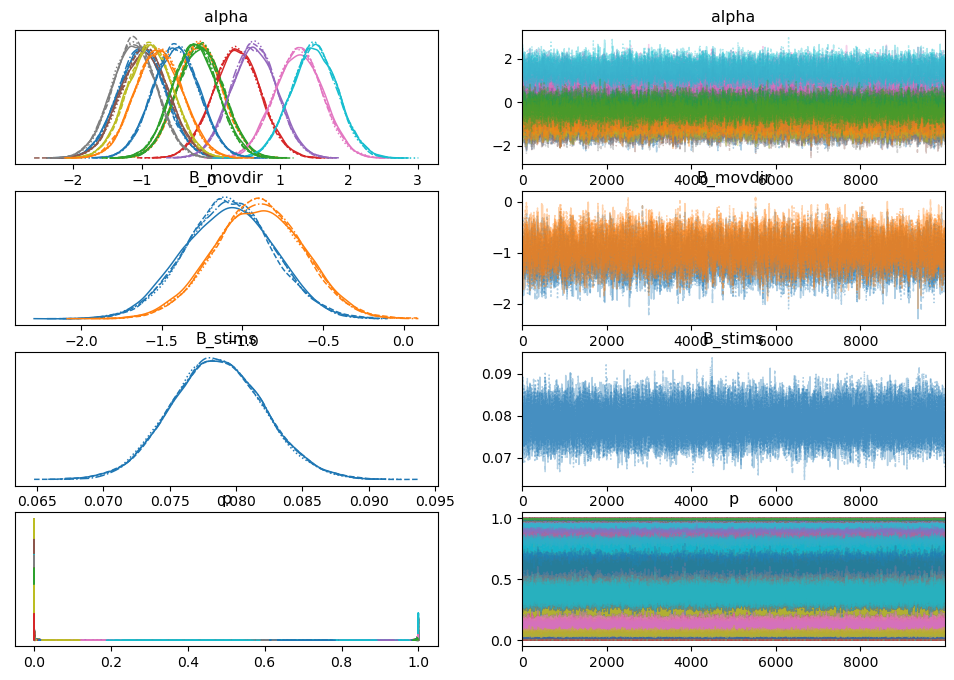

In [11]:
#Trace
az.plot_trace(trace_logistic)
plt.show()

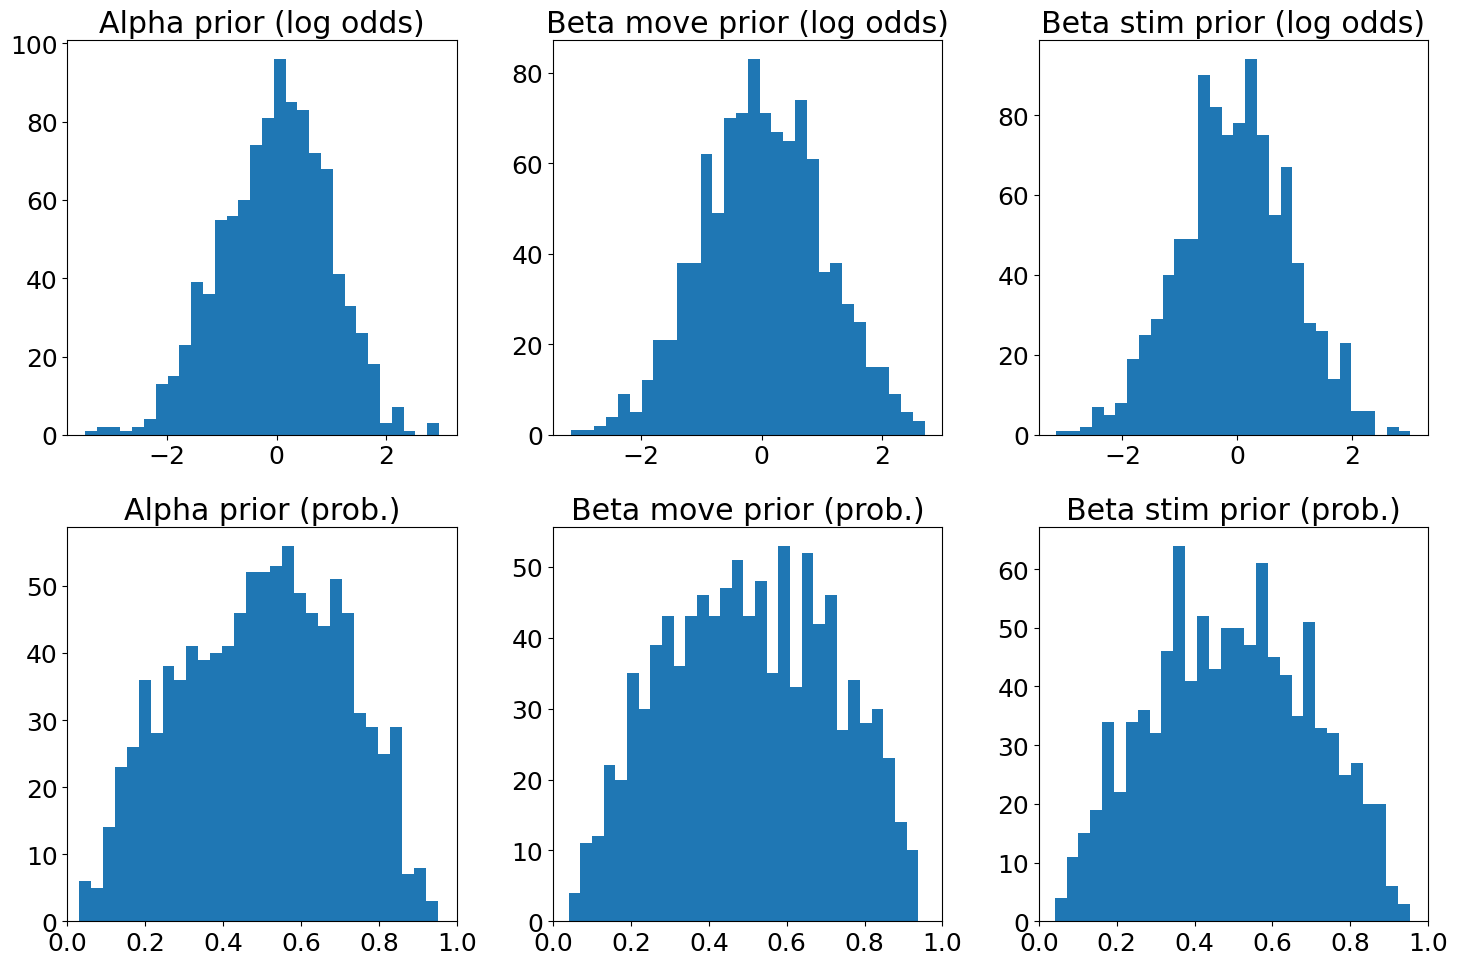

In [12]:
#Priors
log_prior_stack = az.extract(prior_samples_logistic.prior)
bins = 30

fig, ax = plt.subplots(2,3, figsize=(15,10), tight_layout=True)
ax[0,0].hist(log_prior_stack.alpha.values[0,:],bins)
ax[0,0].set(title='Alpha prior (log odds)')
ax[0,1].hist(log_prior_stack.B_movdir.values[0,:],bins)
ax[0,1].set(title='Beta move prior (log odds)')
ax[0,2].hist(log_prior_stack.B_stims.values,bins)
ax[0,2].set(title='Beta stim prior (log odds)')

#Priors
ax[1,0].hist(logistic(log_prior_stack.alpha.values[0,:]),bins)
ax[1,0].set(title='Alpha prior (prob.)', xlim=(0,1))
ax[1,1].hist(logistic(log_prior_stack.B_movdir.values[0,:]),bins)
ax[1,1].set(title='Beta move prior (prob.)', xlim=(0,1))
ax[1,2].hist(logistic(log_prior_stack.B_stims.values),bins)
ax[1,2].set(title='Beta stim prior (prob.)', xlim=(0,1))
plt.show()

## Analyze posterior

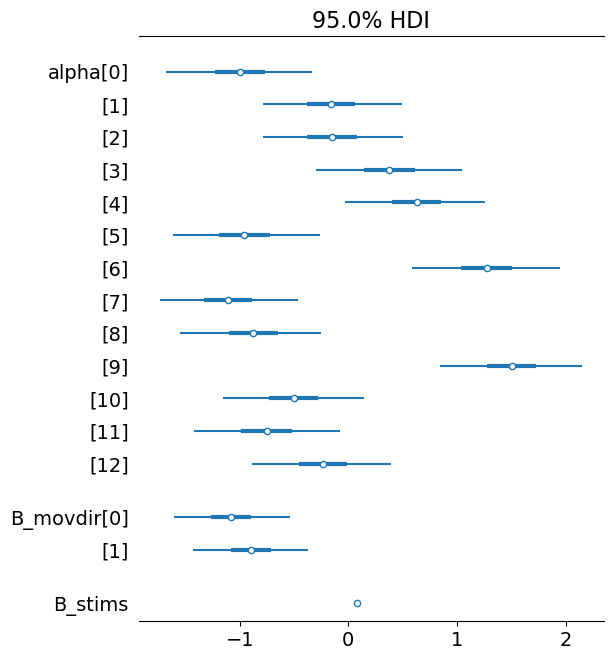

In [13]:
#Summary in log space
az.plot_forest(trace_logistic, var_names=["alpha", "B_movdir", "B_stims"], combined=True, hdi_prob=0.95)
plt.show()

In [14]:
log_summary = az.summary(trace_logistic, var_names=["alpha", "B_movdir", "B_stims"], hdi_prob=0.95)
log_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]    -1.000  0.341    -1.677     -0.338      0.004    0.003    7345.0   
alpha[1]    -0.159  0.327    -0.786      0.494      0.004    0.003    6932.0   
alpha[2]    -0.151  0.332    -0.790      0.503      0.004    0.003    7076.0   
alpha[3]     0.377  0.344    -0.300      1.046      0.004    0.003    7808.0   
alpha[4]     0.627  0.330    -0.034      1.253      0.004    0.003    7208.0   
alpha[5]    -0.959  0.346    -1.615     -0.259      0.004    0.003    7531.0   
alpha[6]     1.273  0.347     0.586      1.944      0.004    0.003    7687.0   
alpha[7]    -1.108  0.324    -1.737     -0.466      0.004    0.003    6910.0   
alpha[8]    -0.874  0.331    -1.552     -0.255      0.004    0.003    7055.0   
alpha[9]     1.501  0.336     0.840      2.154      0.004    0.003    6922.0   
alpha[10]   -0.504  0.334    -1.158      0.146      0.004    0.003    7329.0   
alpha[11]   -0.753  0.344    -1.425     -0.078      0.004    0.003    7612.0   
alpha[12]   -0.232  0.327    -0.884      0.394      0.004    0.003    6866.0   
B_movdir[0] -1.083  0.272    -1.602     -0.539      0.004    0.003    4855.0   
B_movdir[1] -0.901  0.272    -1.435     -0.371      0.004    0.003    4782.0   
B_stims      0.079  0.003     0.072      0.085      0.000    0.000   25351.0   

             ess_tail  r_hat  
alpha[0]      14522.0    1.0  
alpha[1]      13283.0    1.0  
alpha[2]      13496.0    1.0  
alpha[3]      15404.0    1.0  
alpha[4]      14320.0    1.0  
alpha[5]      15931.0    1.0  
alpha[6]      15447.0    1.0  
alpha[7]      13859.0    1.0  
alpha[8]      14674.0    1.0  
alpha[9]      14548.0    1.0  
alpha[10]     14690.0    1.0  
alpha[11]     15874.0    1.0  
alpha[12]     14058.0    1.0  
B_movdir[0]    9110.0    1.0  
B_movdir[1]    9024.0    1.0  
B_stims       28549.0    1.0

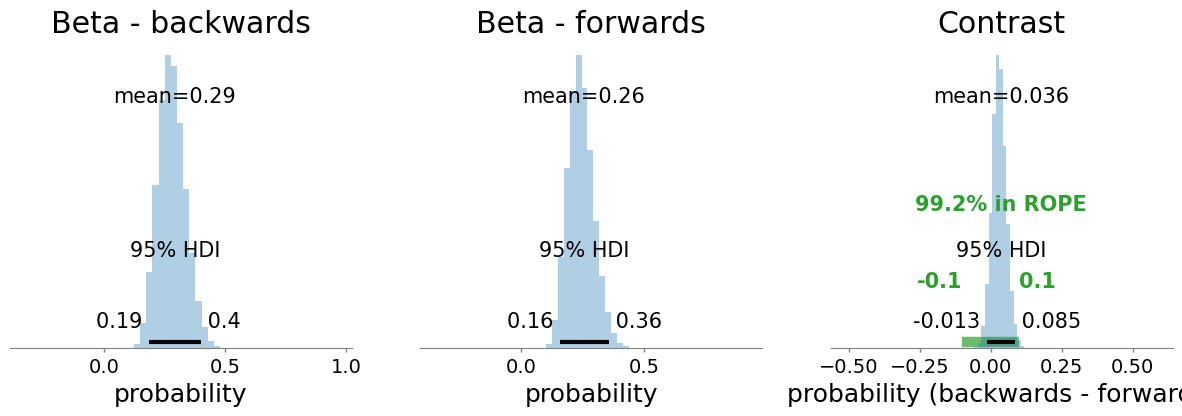

In [15]:
#Sample posterior 
log_posterior_stack = az.extract(trace_logistic.posterior) #Note: for indexing the movement direction posterior, 1 = backwards, 0 = forwards
#Calculate the contrast for movement direction
contrast = logistic(log_posterior_stack.B_movdir.values[1,:]) - logistic(log_posterior_stack.B_movdir.values[0,:])

#Define rope
rope_logistic_prob = 0.1

#Plot
fig, ax = plt.subplots(1,3, figsize=(15,4))
az.plot_posterior(logistic(log_posterior_stack.B_movdir.values[1,:]),kind='hist',hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Beta - backwards',xlabel='probability')
az.plot_posterior(logistic(log_posterior_stack.B_movdir.values[0,:]),kind='hist',hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Beta - forwards',xlabel='probability')
az.plot_posterior(contrast, kind='hist', rope=(-rope_logistic_prob,rope_logistic_prob), hdi_prob=0.95, ax=ax[2])
ax[2].set(title='Contrast',xlabel='probability (backwards - forwards)')
plt.show()

## Plot

In [16]:
# Emperical movement direction probabilities
p_left_back, p_left_fwd = [],[]
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    movement_direction = np.array(test.AllStarts.values > test.AllStims.values, dtype=int)
    p_lft_indiv_bck, p_lft_indiv_fwd = calc_response_prob(movement_direction, test.BinaryResponses)
    p_left_back.append(p_lft_indiv_bck)
    p_left_fwd.append(p_lft_indiv_fwd)
    
#Calculate HDI and percent in rope
hdi_95_contrast = az.hdi(contrast, hdi_prob=0.95)
prct_in_rope = (np.sum((contrast>-rope_logistic_prob) & (contrast<rope_logistic_prob)) / len(contrast))*100

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_57310/448459857.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


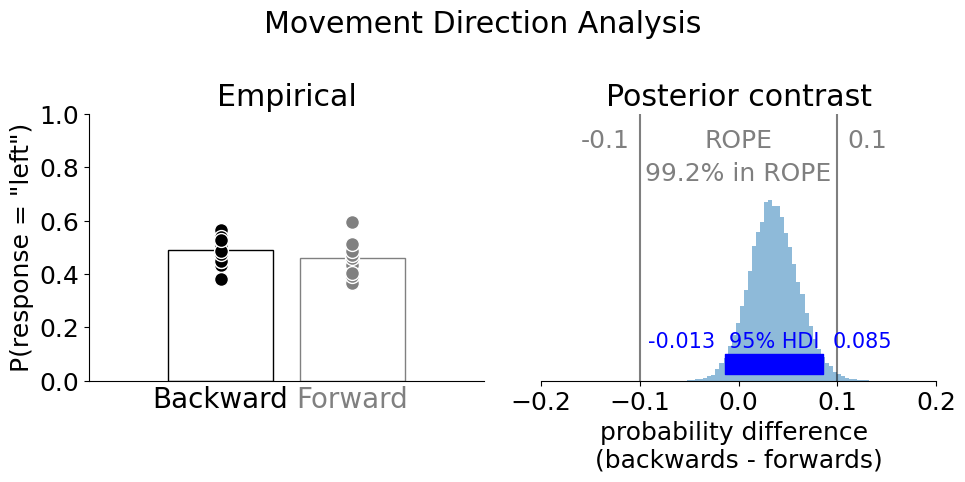

In [17]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]}, tight_layout=True)

ax[0].plot(np.ones_like(p_left_back)*0, p_left_back, 'o', color=color_bottom, mec='w', ms=10)
ax[0].plot(np.ones_like(p_left_fwd), p_left_fwd, 'o', color=color_top, mec='w', ms=10)
ax[0].bar(0, np.mean(p_left_back), edgecolor=color_bottom, color='none')
ax[0].bar(1, np.mean(p_left_fwd), edgecolor=color_top, color='none')
ax[0].set(ylim=(0,1), xlim=(-1,2), xticks=[], title='Empirical', facecolor = "none", ylabel='P(response = "left")') 
ax[0].text(0, -0.1, 'Backward', color=color_bottom, size=20, ha='center')
ax[0].text(1, -0.1, 'Forward', color=color_top, size=20, ha='center')
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)

ax[1].vlines([-rope_logistic_prob, rope_logistic_prob], ymin=[0,0], ymax=[10000,10000], color='k', alpha=0.5)
ax[1].hist(contrast, 50, alpha=0.5)
ax[1].text(0, 3500, 'ROPE', ha='center', alpha=0.5)
ax[1].text(0, 3000, str(round(prct_in_rope,1)) + '% in ROPE', ha='center', alpha=0.5)
ax[1].text(-rope_logistic_prob-0.01, 3500, '-0.1', ha='right', alpha=0.5)
ax[1].text(rope_logistic_prob+0.01, 3500, '0.1', ha='left', alpha=0.5)
ax[1].fill_between(hdi_95_contrast, y1=np.zeros_like(hdi_95_contrast)+100, y2=np.zeros_like(hdi_95_contrast)+400, color='b')
ax[1].text(np.mean(contrast),500, '95% HDI', ha='center', color='b', size=15)
ax[1].text(hdi_95_contrast[0]-0.01, 500, str(np.round(hdi_95_contrast[0],3)), ha='right', size=15, color='b')
ax[1].text(hdi_95_contrast[1]+0.01, 500, str(np.round(hdi_95_contrast[1],3)), ha='left', size=15, color='b')
ax[1].set(title='Posterior contrast', xlabel='probability difference \n' + '(backwards - forwards)', yticks=[], xlim=(-0.2,0.2), ylim=(0,4000))
top_side = ax[1].spines["top"]
top_side.set_visible(False)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
left_side = ax[1].spines["left"]
left_side.set_visible(False)

plt.suptitle('Movement Direction Analysis')
plt.savefig(fig_path + '/Move_Dir_Fig' + extension, transparent=True, bbox_inches='tight', pad_inches=1, edgecolor='w', dpi=1500)
plt.show()

# Bland-Altman analysis 

This analysis has 3 parts:
1. Determine if there is a mean bias in the differences between individual scores. A test with good agreement should not have a bias. 
2. Determine if there is a bias across different "true" scores. Our best guess for the true score is the mean between the individual scores. So we can perform a regression with the individual mean scores as the predictor variable and the difference in individual scores as the outcome variable. A test with good agreement will have a slope that is not different from 0, indicating that there is not a bias across the different "true" scores. 
3. Define the limits of agreement. Bland-altman defined the limits of agreement as the difference in individual scores that contains 95% of the data. 

## 1. Mean bias

### Define the model

we determined if there was a mean bias by estimating the distribution of differences between Test 1 and Test 2 for the threshold and uncertainty estimates separately. Since these differences were continuous, we modeled them as a normal distribution, estimating the most likely set of population $\mu$ and $\sigma$ values that generated the data:

$$ MeanDifference \sim Normal(\mu, \sigma) $$
$$ \mu \sim Normal(0,20) $$
$$ \sigma \sim Exp(20) $$

**Define the priors:**

The prior for mu is set around 0 with an SD of 20mm, while the prior for sigma is exponentnial with an expected value of 20

* A wide prior of mu=0, sigma=50 does not change the results.
* A narrow prior, mu=0, sigma=5. This made the results more robust, meaning more of the posterior was in the ROPE for both, but overall, the results are unchanged. 
Next I modified the prior for sigma, the standard deviation of the normal distribution:
* First, I tried a wider prior of 0.01, an EV of 100, this didnt change any of the results
* Next, I went narrow with a prior of 1, and EV of 1, but this also does not change the results

**Variables:**

Here we just need the difference between alpha and beta estimates between Test 1 and Test 2

**ROPE Justification:**

For the purposes of our lower extremity proprioception task, which had intervals provided every 10mm, it is fair to assume that a difference of plus or minus half a stimulus step is practically equivilant. Thus, any bias within 5mm in either direction is practically equivilant. 

### Calculate the posteriors

In [18]:
#Alpha
prior_samples_abias, trace_alpha_bias, = bayes_onesamp_ttest(alpha_diff, prior=[0,20])
#Beta
prior_samples_bbias, trace_beta_bias = bayes_onesamp_ttest(beta_diff, prior=[0,20])

Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 24 seconds.
Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 23 seconds.


### Model checks

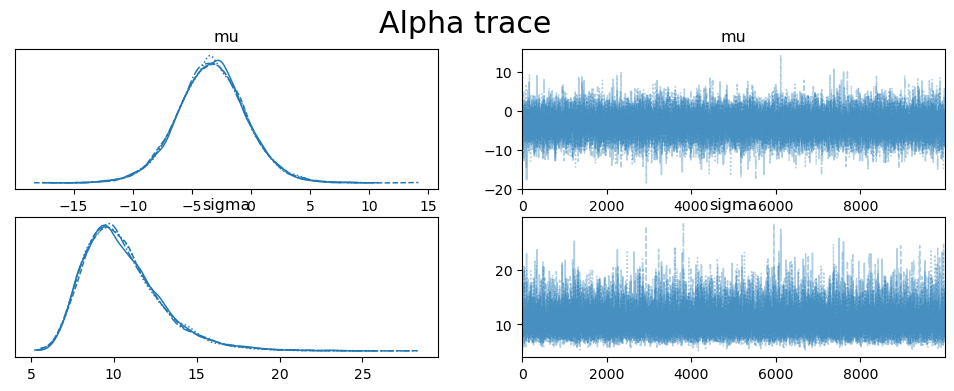

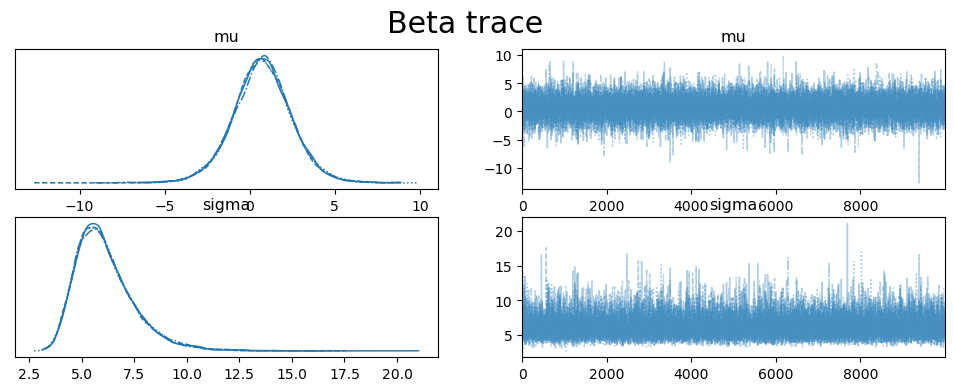

In [19]:
#Trace
#Alpha
az.plot_trace(trace_alpha_bias)
plt.suptitle('Alpha trace')
plt.show()
#Beta
az.plot_trace(trace_beta_bias)
plt.suptitle('Beta trace')
plt.show()

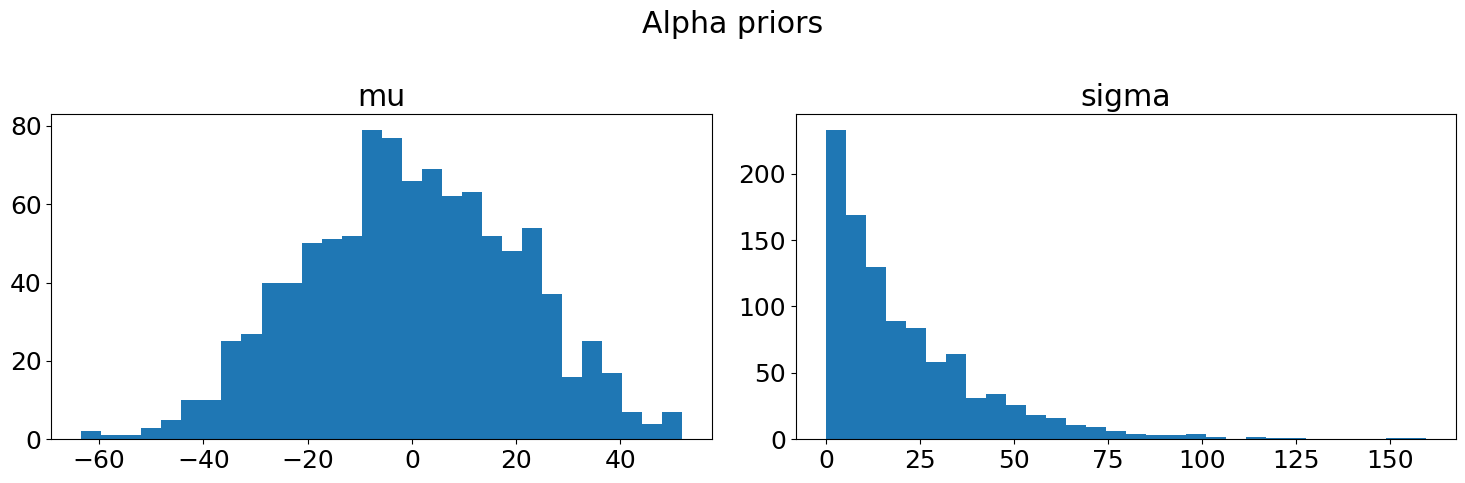

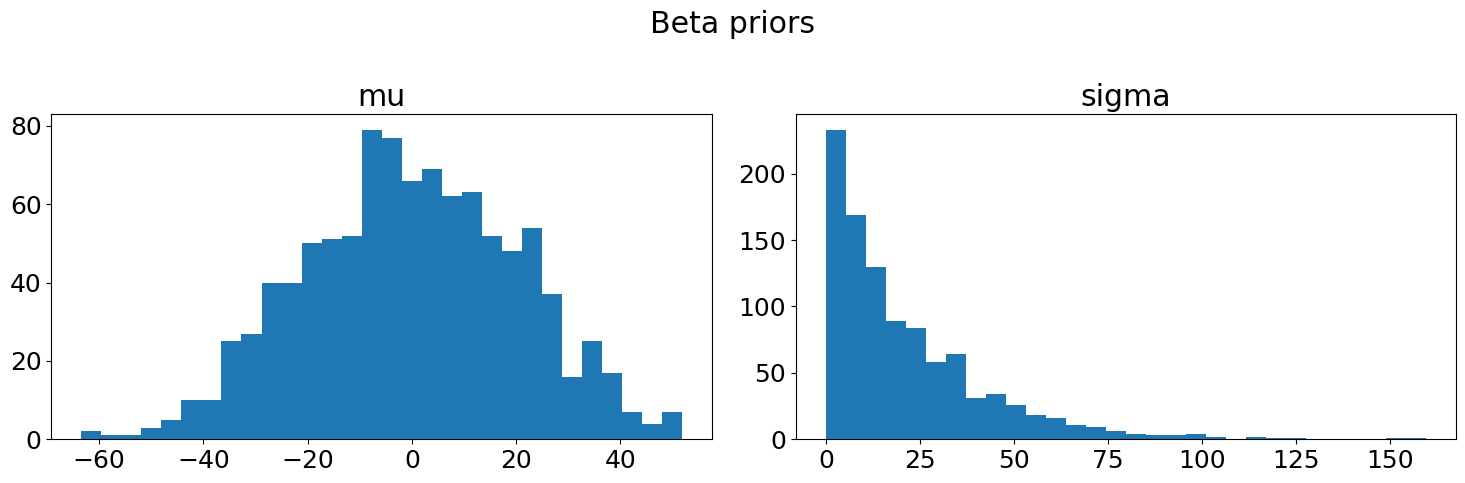

In [20]:
#Priors
abias_prior_stack = az.extract(prior_samples_abias.prior)
bbias_prior_stack = az.extract(prior_samples_bbias.prior)

bins = 30

#Alpha
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
ax[0].hist(abias_prior_stack.mu.values, bins)
ax[0].set(title='mu')
ax[1].hist(abias_prior_stack.sigma.values, bins)
ax[1].set(title='sigma')
plt.suptitle('Alpha priors')
plt.show()

#Beta
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
ax[0].hist(bbias_prior_stack.mu.values, bins)
ax[0].set(title='mu')
ax[1].hist(bbias_prior_stack.sigma.values, bins)
ax[1].set(title='sigma')
plt.suptitle('Beta priors')
plt.show()

### Analyze posterior

In [21]:
a_bias_summary = az.summary(trace_alpha_bias, var_names=["mu", "sigma"], hdi_prob=0.95)
b_bias_summary = az.summary(trace_beta_bias, var_names=["mu", "sigma"], hdi_prob=0.95)
print('Alpha posterior:')
display(a_bias_summary)
print('Beta posterior:')
display(b_bias_summary)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     -3.334  2.956    -8.915      2.818      0.018    0.014   28905.0   
sigma  10.526  2.385     6.627     15.337      0.015    0.011   26355.0   

       ess_tail  r_hat  
mu      23649.0    1.0  
sigma   25039.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.723  1.742    -2.903      4.060       0.01    0.009   28964.0   
sigma  6.108  1.423     3.789      8.942       0.01    0.007   24021.0   

       ess_tail  r_hat  
mu      22658.0    1.0  
sigma   21997.0    1.0

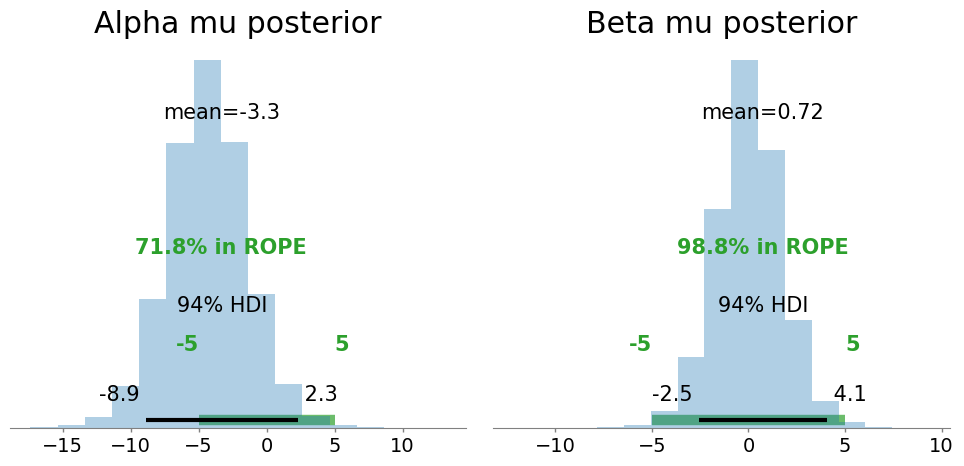

In [22]:
#Plot
abias_posterior_stack = az.extract(trace_alpha_bias.posterior)
bbias_posterior_stack = az.extract(trace_beta_bias.posterior)

#Define rope
rope_mu_diff = 5

fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
az.plot_posterior(abias_posterior_stack.mu.values,kind='hist', rope=(-rope_mu_diff,rope_mu_diff), ax=ax[0])
ax[0].set(title='Alpha mu posterior')
az.plot_posterior(bbias_posterior_stack.mu.values,kind='hist', rope=(-rope_mu_diff,rope_mu_diff), ax=ax[1])
ax[1].set(title='Beta mu posterior')
plt.show()

## 2. Bias across 'true' scores

### Define the model

we determined if there was a bias across the range of “true” values of threshold and uncertainty. We used two separate Bayesian regressions where the true values predict the difference in threshold/uncertainty values. Since we can never know the true value, our best guess is each individual’s mean value between Test 1 and 2. We used a Bayesian regression analysis where the outcome variable, the individual differences ($Y_{difference}$), was modeled as a normal distribution with the mean ($\mu$) being predicted by the “true” threshold/uncertainty value ($x_{true}$):

$$ Y_{difference, i} \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{intercept} + \beta_{slope}*X_{true} $$
$$ \alpha_{intercept} \sim Normal(0, 20) $$ 
$$ \beta_{slope} \sim Normal(0,1) $$
$$ \sigma \sim Exp(20) $$

**Prior justification:**

Given the rage of the data, we make an initial guess that the slope of this relationship is centered on 0 with a good amount of uncertainty to not overwhelm the likelihood: N(0,1). For the incercept, we assume that when the mean of the scores is 0, we make a guess that the difference in scores is centered on 0 with a wide SD: N(0,20). The sigma of the distibution of differences has an expected value of 20. 

*Intercept:* 
* First I increased the sigma to 20. This really increases the uncertainty. The prior predictive checks are now all over the place. This widens the posterior distributions, mostly for the intercepts. 
* Next, I decreased the sigma to 1, as expected this really narrows the posterior for intercept.

*Slope:*
* If I also widen the prior for the slope from mu=0, sigma=1 to sigma=5. This really does not change much.
* When I narrow down the prior for slope from 1 to 0.1, this narrows the posterior by a lot. 

*Sigma:*
* Lastly, I changed the priors for sigma. The one I am using are 0.05, and EV of 20. I also looked at an EV of 1 and 100. Neither changed the posterior a great deal. 

**Variables justification:**

I need the difference in individual estiamtes and the mean of individual estiamtes

**ROPE justification:**

Here I define ropes for the intercept and slope. Lets start with the intercept. Here, the intercept is defined as the difference between the estimates on Test 1 and 2 when the mean of the estimates on Test 1 and 2 equals 0. In other words, when the true score is 0, what is the difference between the scores? We can use similar logic as I used for the mean bias ROPE above, where for practical purposes, a difference inside of 5mm on either side is practically equivilant.

Now for the slope. First we have to consider what the slope means in this context. Here the slope is a rate of change of estimate differences based on the true score. Thus, a slope of 0.1 means that if the true score changes 10mm, there is a 1mm change in score difference. If the test is perfectly unbiased, there should be a slope of 0. So what is the largest slope that is practically 0 for our purposes? For the current study, a slope between -0.1 and 0.1 should be considered practically equivilant because this yields a very small change in score difference when the true score changes by 1 step. 

### Calculcate the posteriors

In [23]:
#Alpha
trace_alpha_diff_regress, prior_samples_adiff_regress = bayes_simple_regression(alpha_diff, alpha_mean, intercept_prior=[0,20], slope_prior=[0,2])
#Beta
trace_beta_diff_regress, prior_samples_bdiff_regress = bayes_simple_regression(beta_diff, beta_mean, intercept_prior=[0,20], slope_prior=[0,2])

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 27 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 33 seconds.


### Model checks

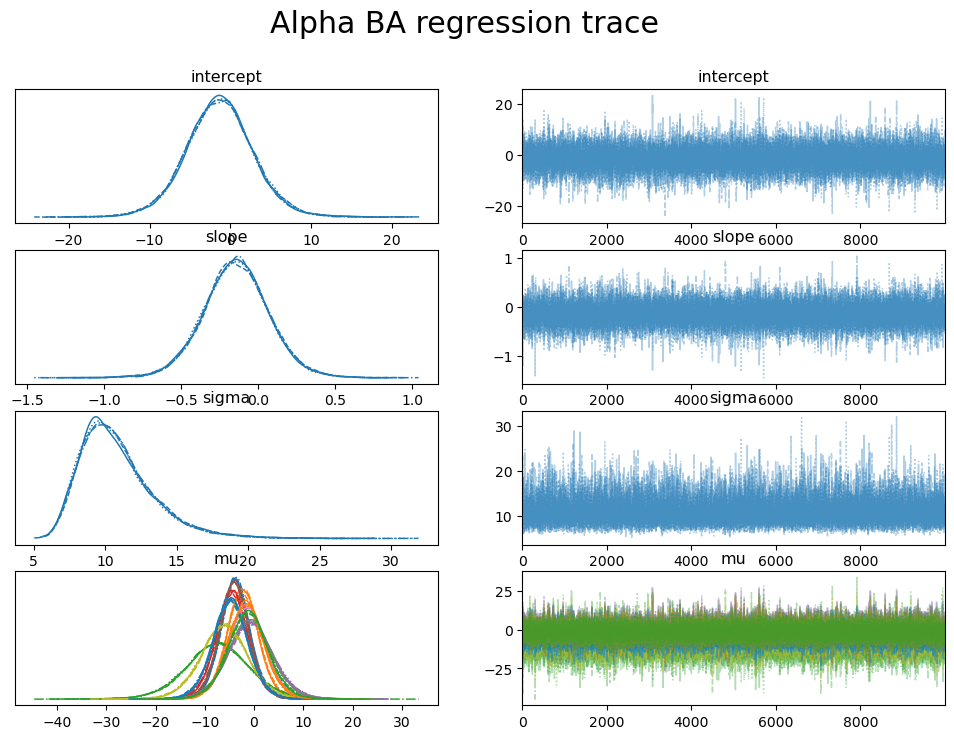

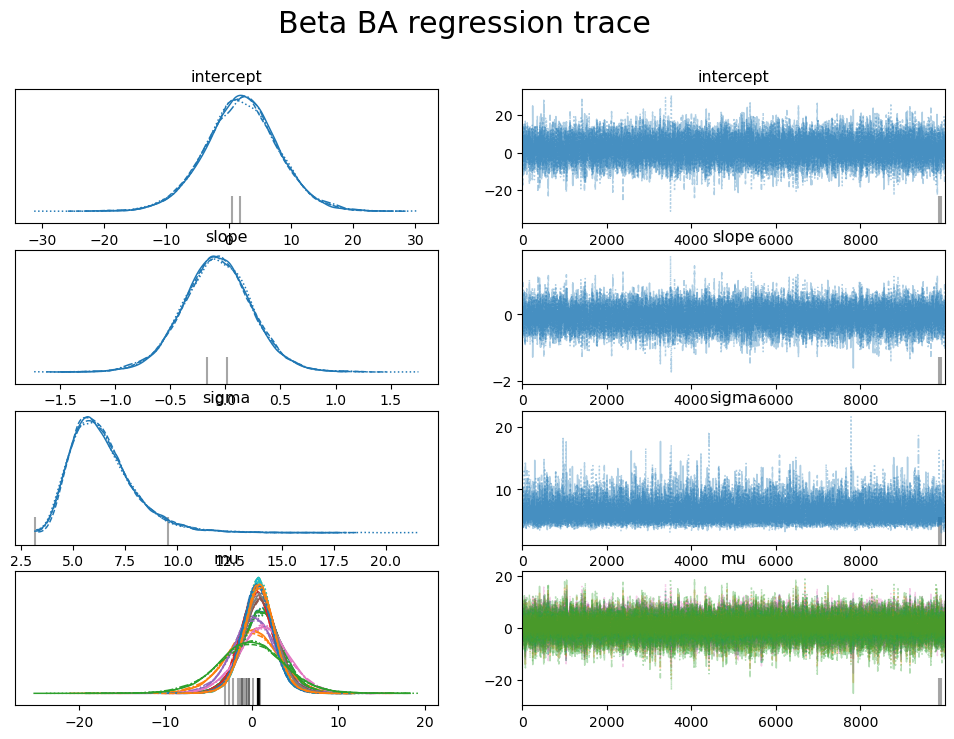

In [24]:
#Traces
#Alpha
az.plot_trace(trace_alpha_diff_regress)
plt.suptitle('Alpha BA regression trace')
plt.show()
#Beta
az.plot_trace(trace_beta_diff_regress)
plt.suptitle('Beta BA regression trace')
plt.show()

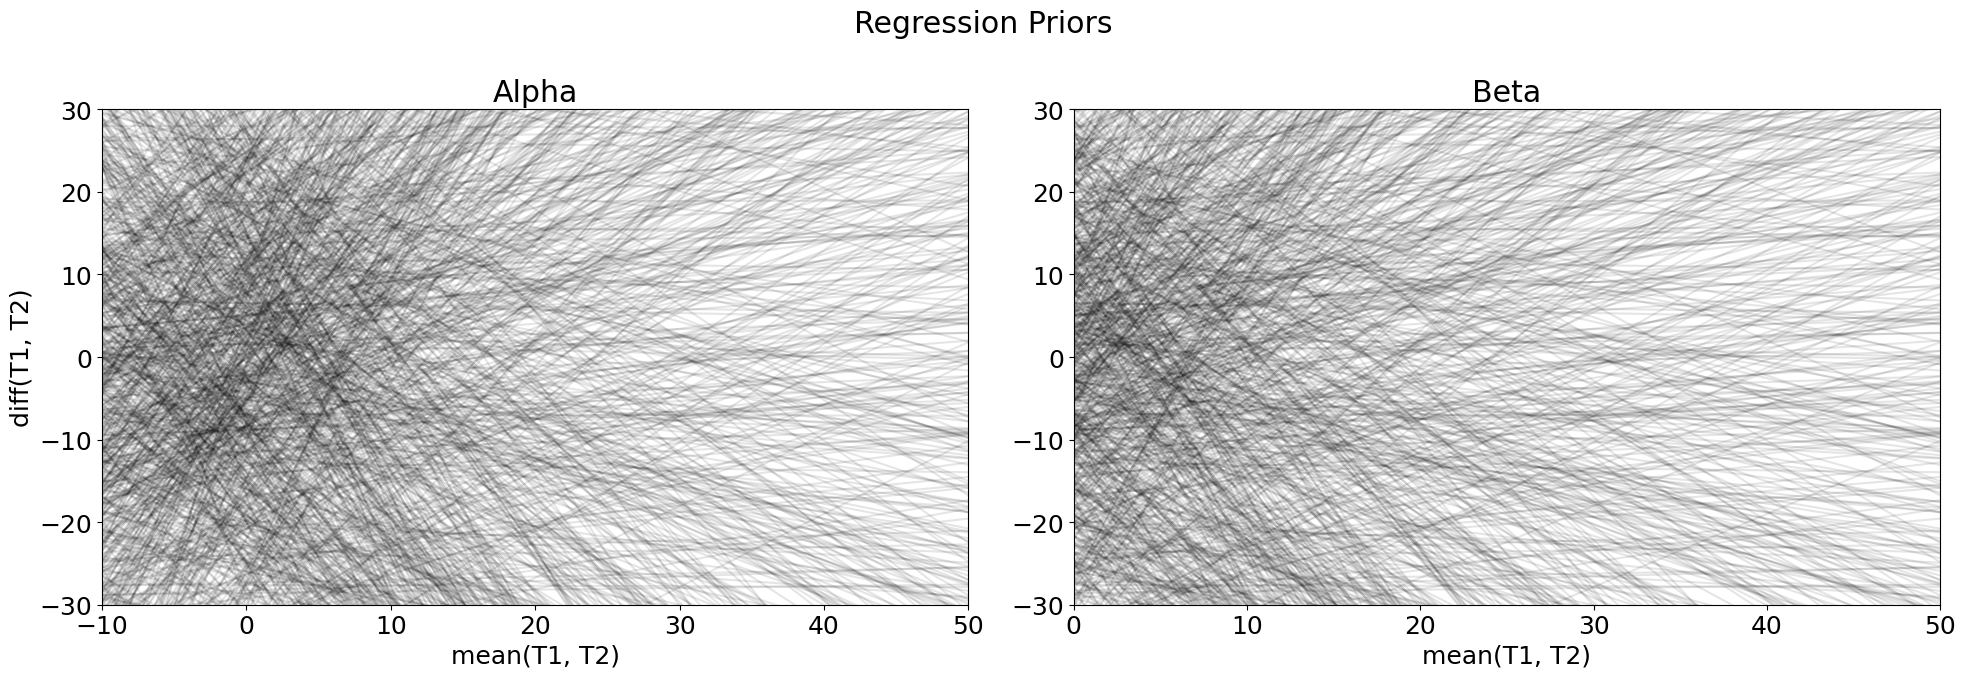

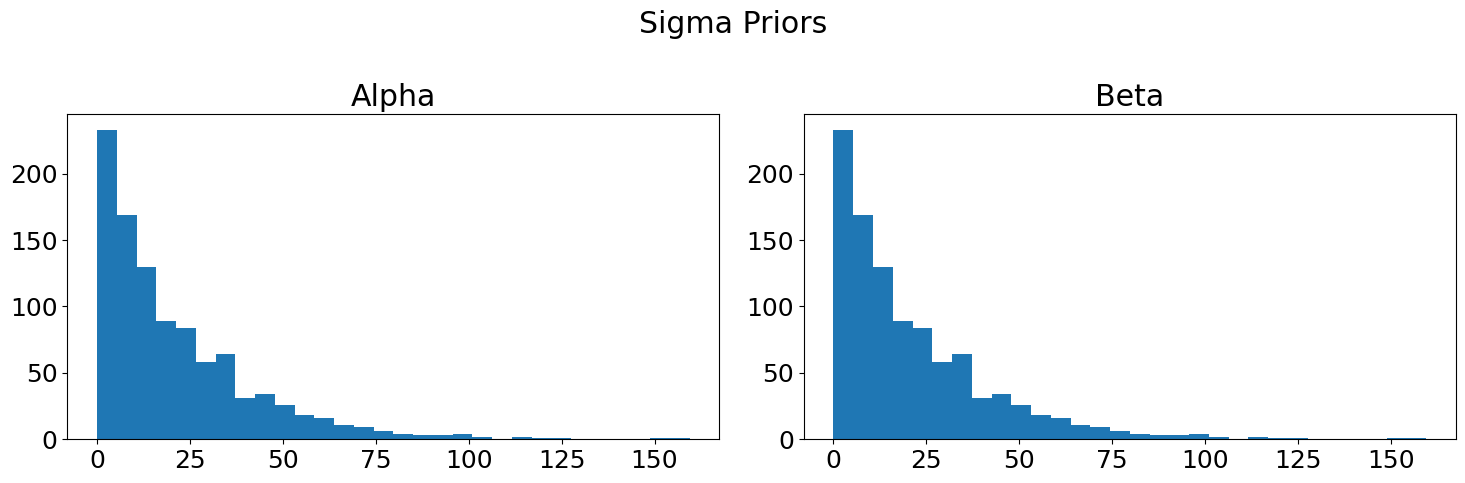

In [25]:
#Priors
abias_regress_prior_stack = az.extract(prior_samples_adiff_regress.prior)
bbias_regress_prior_stack = az.extract(prior_samples_bdiff_regress.prior)

#Priors
# Make sure the priors are reasonable 
fig, ax = plt.subplots(1,2, figsize=(20,7),tight_layout=True)

x_alpha = np.linspace(-10, 51, 100)
for a, b in zip(abias_regress_prior_stack.intercept.values, abias_regress_prior_stack.slope.values):
    y_alpha = a + b * x_alpha
    ax[0].plot(x_alpha, y_alpha, c="black", alpha=0.1)

x_beta = np.linspace(0, 51, 100)
for a, b in zip(bbias_regress_prior_stack.intercept.values, bbias_regress_prior_stack.slope.values):
    y_beta = a + b * x_beta
    ax[1].plot(x_beta, y_beta, c="black", alpha=0.1)
    
# ax.plot(np.arange(-10,51),np.zeros(61),'k--')
ax[0].set(xlabel='mean(T1, T2)', ylabel='diff(T1, T2)', xlim=(-10, 50), ylim=(-30,30), title='Alpha')
ax[1].set(xlabel='mean(T1, T2)', xlim=(0, 50), ylim=(-30,30), title='Beta')
plt.suptitle('Regression Priors')
plt.show()

#Prior for sigma
bins = 30

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
ax[0].hist(abias_regress_prior_stack.sigma.values, bins)
ax[0].set(title='Alpha')
ax[1].hist(bbias_regress_prior_stack.sigma.values, bins)
ax[1].set(title='Beta')
plt.suptitle('Sigma Priors')
plt.show()

### Analyze posterior

In [26]:
alpha_regress_summary = az.summary(trace_alpha_diff_regress, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
print('Alpha posterior:')
display(alpha_regress_summary)
beta_regress_summary = az.summary(trace_beta_diff_regress, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
print('Beta posterior:')
display(beta_regress_summary)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -1.361  4.211    -9.423      7.239      0.032    0.025   18187.0   
slope      -0.145  0.217    -0.572      0.281      0.002    0.001   17343.0   
sigma      10.810  2.599     6.605     16.048      0.020    0.014   17982.0   

           ess_tail  r_hat  
intercept   19745.0    1.0  
slope       18775.0    1.0  
sigma       19903.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  2.088  5.905    -9.900     13.572      0.053    0.040   12497.0   
slope     -0.078  0.319    -0.704      0.567      0.003    0.002   12565.0   
sigma      6.404  1.547     3.879      9.457      0.013    0.010   13593.0   

           ess_tail  r_hat  
intercept   14325.0    1.0  
slope       14221.0    1.0  
sigma       12725.0    1.0

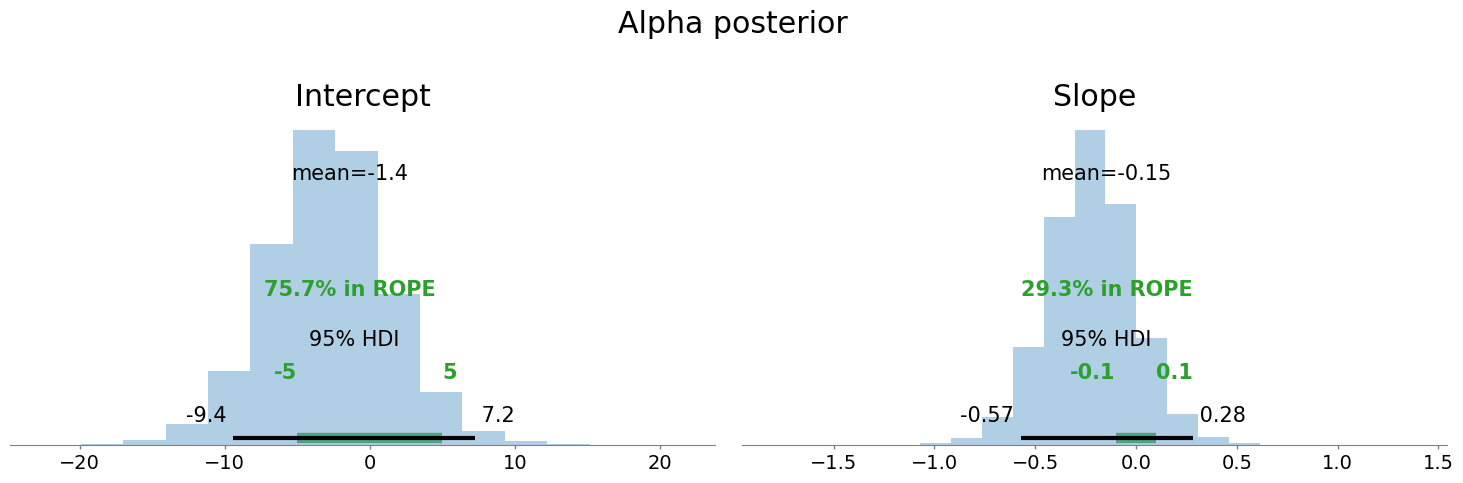

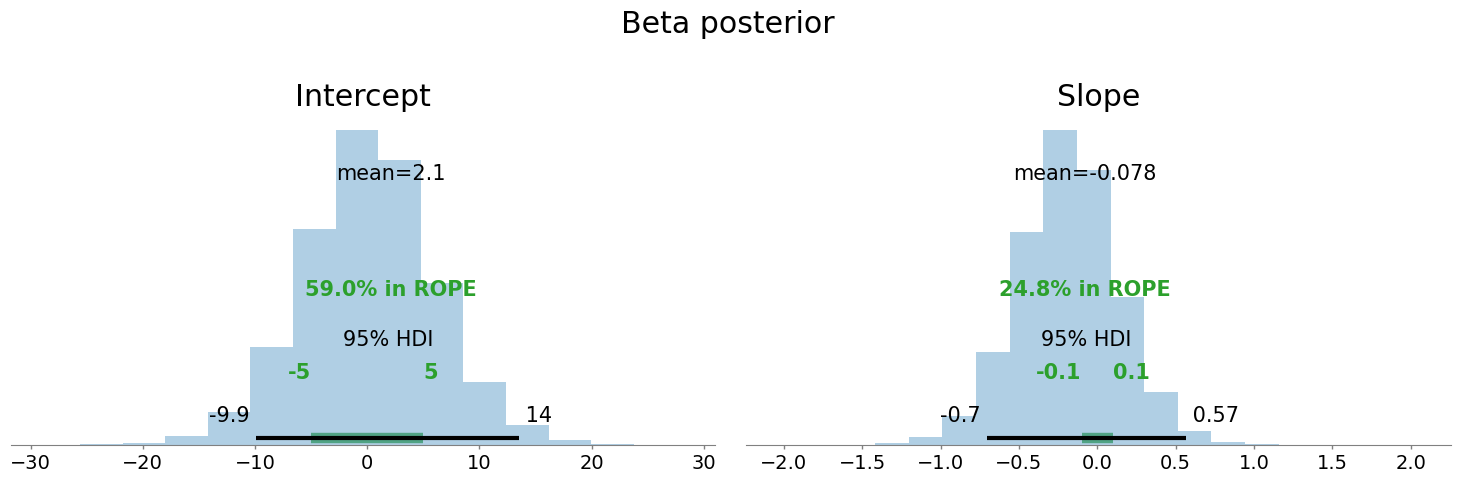

In [27]:
#Sample posterior 
abias_regress_posterior_stack = az.extract(trace_alpha_diff_regress.posterior)
bbias_regress_posterior_stack = az.extract(trace_beta_diff_regress.posterior)

#Define ROPE
rope_intercept = 5
rope_slope = 0.1

#Plot alpha
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
az.plot_posterior(abias_regress_posterior_stack.intercept.values,kind='hist', rope=(-rope_intercept,rope_intercept), hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Intercept')
az.plot_posterior(abias_regress_posterior_stack.slope.values,kind='hist',  rope=(-rope_slope, rope_slope), hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Slope')
plt.suptitle('Alpha posterior')
plt.show()

#Plot beta
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
az.plot_posterior(bbias_regress_posterior_stack.intercept.values,kind='hist', rope=(-rope_intercept,rope_intercept), hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Intercept')
az.plot_posterior(bbias_regress_posterior_stack.slope.values,kind='hist',  rope=(-rope_slope, rope_slope), hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Slope')
plt.suptitle('Beta posterior')
plt.show()

## 3. Limits of agreement (emperical)

In [28]:
#Limits of agreement
uplimit_alpha = np.mean(alpha_diff) + 1.96*np.std(alpha_diff, ddof=1)
lolimit_alpha = np.mean(alpha_diff) - 1.96*np.std(alpha_diff, ddof=1)

uplimit_beta = np.mean(beta_diff) + 1.96*np.std(beta_diff, ddof=1)
lolimit_beta = np.mean(beta_diff) - 1.96*np.std(beta_diff, ddof=1)

print('Alpha limits of agreement: ' + str(round(lolimit_alpha,1)) + ' to ' + str(round(uplimit_alpha,1)))
print('Beta limits of agreement: ' + str(round(lolimit_beta,1)) + ' to ' + str(round(uplimit_beta,1)))

Alpha limits of agreement: -22.3 to 15.5
Beta limits of agreement: -10.1 to 11.6


# Regression 

## Define the model

We characterized the strength of the relationship between Test 1 and Test 2 for both the threshold and uncertainty estimates. We again used a Bayesian regression model, except the estimate on Test 2 was the outcome variable ($Y_{Test2}$) and the estimate on Test 1 was the predictor variable ($X_{Test1}$):

$$ Y_{Test2,i} \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{intercept} + \beta_{slope}*X_{Test1,i} $$
$$ \alpha_{intercept} \sim Normal(0, 20) $$ 
$$ \beta_{slope} \sim Normal(0,2) $$
$$ \sigma \sim Exp(20) $$

**Define the priors:**

I started with priors for the intercept of mu=0, sigma=20. I made the prior for slope cenetered on 0 with a SD of 2. The prior for the sigma parameter is 0.05. This is the same as an expected value of 20 becauase the parameterization for the Exponential function is: mean = 1/lambda. Where the lambda is the parameter.

This posterior is robust to pretty much all changes I made to the prior. Sometimes the 95% HDIs are narrower or wider for the slopes and intercepts 
If I widen the intercept priors from 20 to 50, this really doesnt change the posterior at all. If I narrow the intercept to around 5, this narrows the beta estimates for intercept and slope but does not change the threshold estimates very much. For the slope priors, I have them centered on 1 with a sigma of 2. I tried narrowing the slope down to 1 but this didnt change the estimates for slope very much. 

**Variables**

Just need Test 1 and Test 2

## Calculcate the posteriors

In [29]:
#Alpha
trace_alpha_regress, prior_samples_aregress = bayes_simple_regression(alphas[:,1], alphas[:,0], intercept_prior=[0,20], slope_prior=[0,2])
#Beta
trace_beta_regress, prior_samples_bregress = bayes_simple_regression(betas[:,1], betas[:,0], intercept_prior=[0,20], slope_prior=[0,2])

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 27 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 32 seconds.


## Model checks

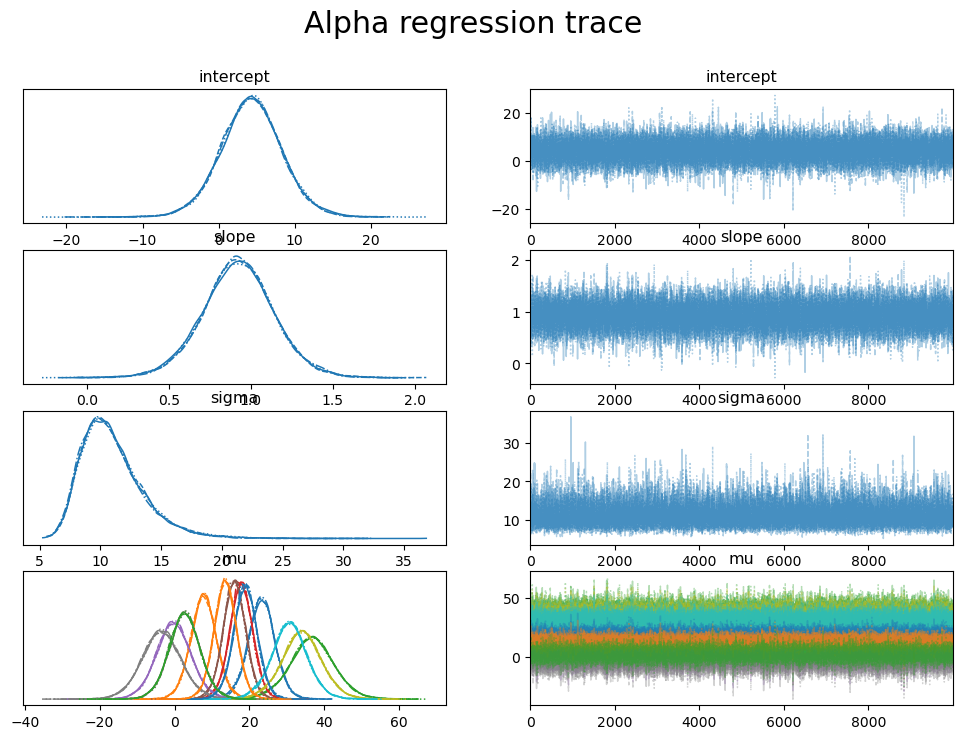

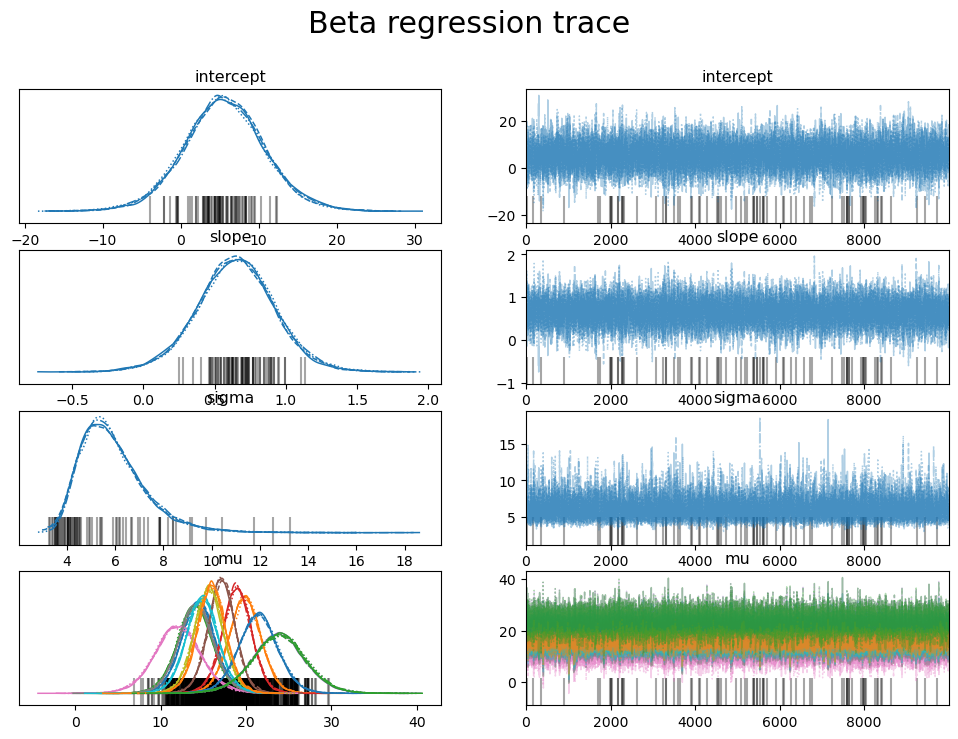

In [30]:
#Traces
#Alpha
az.plot_trace(trace_alpha_regress)
plt.suptitle('Alpha regression trace')
plt.show()
#Beta
az.plot_trace(trace_beta_regress)
plt.suptitle('Beta regression trace')
plt.show()

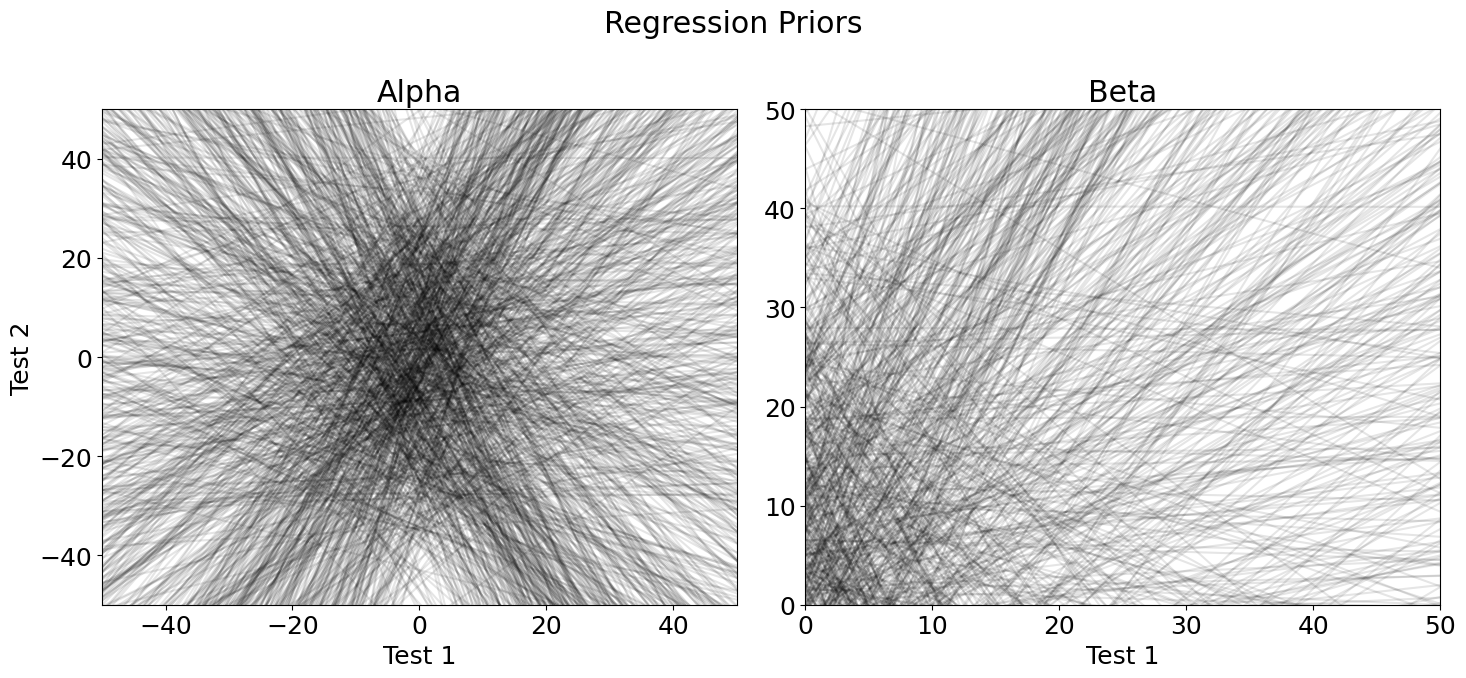

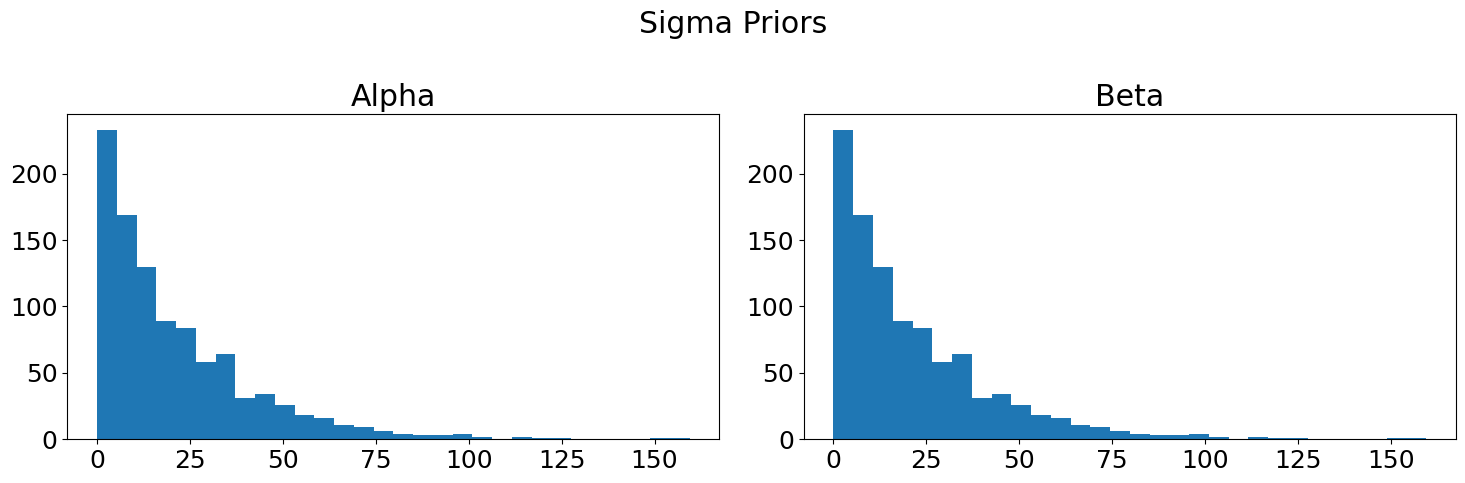

In [31]:
#Make sure the priors are reasonable 
aregress_prior_stack = az.extract(prior_samples_aregress.prior)
bregress_prior_stack = az.extract(prior_samples_bregress.prior)

fig, ax = plt.subplots(1,2, figsize=(15,7),tight_layout=True)

x_alpha = np.linspace(-50, 51, 100)
for a, b in zip(aregress_prior_stack.intercept.values, aregress_prior_stack.slope.values):
    y_alpha = a + b * x_alpha
    ax[0].plot(x_alpha, y_alpha, c="black", alpha=0.1)

x_beta = np.linspace(0, 51, 100)
for a, b in zip(bregress_prior_stack.intercept.values, bregress_prior_stack.slope.values):
    y_beta = a + b * x_beta
    ax[1].plot(x_beta, y_beta, c="black", alpha=0.1)
    
# ax.plot(np.arange(-10,51),np.zeros(61),'k--')
ax[0].set(xlabel='Test 1', ylabel='Test 2', xlim=(-50, 50), ylim=(-50,50), title='Alpha')
ax[1].set(xlabel='Test 1', xlim=(0, 50), ylim=(0,50), title='Beta')
plt.suptitle('Regression Priors')
plt.show()

#Prior for sigma
bins = 30

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
ax[0].hist(aregress_prior_stack.sigma, bins)
ax[0].set(title='Alpha')
ax[1].hist(bregress_prior_stack.sigma, bins)
ax[1].set(title='Beta')
plt.suptitle('Sigma Priors')
plt.show()

## Analyze the posterior

In [32]:
regress_summary_alpha = az.summary(trace_alpha_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
regress_summary_beta = az.summary(trace_beta_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
print('Alpha posterior:')
display(regress_summary_alpha)
print('Beta posterior:')
display(regress_summary_beta)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   4.283  4.042    -3.829     12.202      0.029    0.022   20483.0   
slope       0.921  0.223     0.478      1.364      0.002    0.001   20252.0   
sigma      10.980  2.601     6.681     16.167      0.020    0.015   17846.0   

           ess_tail  r_hat  
intercept   20848.0    1.0  
slope       20436.0    1.0  
sigma       19205.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.574  5.271    -4.698     16.367      0.048    0.035   11980.0   
slope      0.650  0.277     0.095      1.202      0.003    0.002   11864.0   
sigma      5.910  1.405     3.616      8.684      0.013    0.009    9940.0   

           ess_tail  r_hat  
intercept   14080.0    1.0  
slope       14090.0    1.0  
sigma        6769.0    1.0

In [33]:
regress_summary_alpha = az.summary(trace_alpha_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
regress_summary_beta = az.summary(trace_beta_regress, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
print('Alpha posterior:')
display(regress_summary_alpha)
print('Beta posterior:')
display(regress_summary_beta)

Alpha posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   4.283  4.042    -3.829     12.202      0.029    0.022   20483.0   
slope       0.921  0.223     0.478      1.364      0.002    0.001   20252.0   
sigma      10.980  2.601     6.681     16.167      0.020    0.015   17846.0   

           ess_tail  r_hat  
intercept   20848.0    1.0  
slope       20436.0    1.0  
sigma       19205.0    1.0

Beta posterior:


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.574  5.271    -4.698     16.367      0.048    0.035   11980.0   
slope      0.650  0.277     0.095      1.202      0.003    0.002   11864.0   
sigma      5.910  1.405     3.616      8.684      0.013    0.009    9940.0   

           ess_tail  r_hat  
intercept   14080.0    1.0  
slope       14090.0    1.0  
sigma        6769.0    1.0

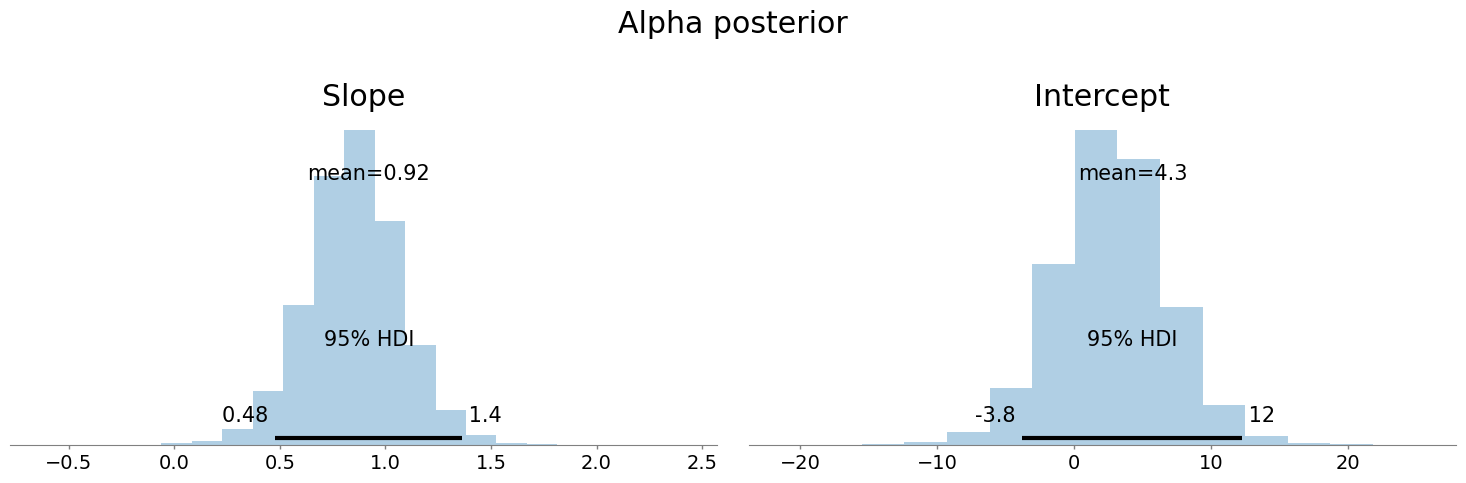

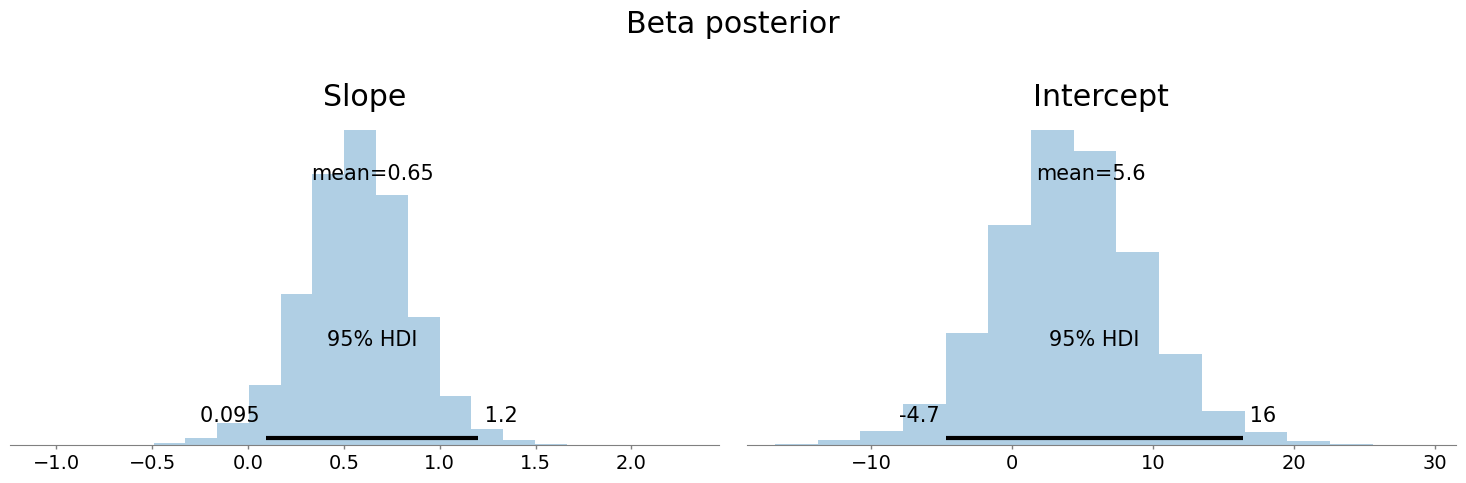

In [34]:
#Plot
aregress_posterior_stack = az.extract(trace_alpha_regress.posterior)
bregress_posterior_stack = az.extract(trace_beta_regress.posterior)

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(aregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(aregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Alpha posterior')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
az.plot_posterior(bregress_posterior_stack.slope.values,kind='hist', hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Slope')
az.plot_posterior(bregress_posterior_stack.intercept.values,kind='hist', hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Intercept')
plt.suptitle('Beta posterior')
plt.show()

# Plot Figure 2

## Prep

In [35]:
#Prep plot for alpha BA regression
x_adiff_regress = np.arange(-5, 45)
mu_hat_adiff_regress = np.zeros((len(x_adiff_regress), len(abias_regress_posterior_stack.intercept.values)))
for i, x in enumerate(x_adiff_regress):
    mu_hat_adiff_regress[i] = abias_regress_posterior_stack.intercept.values + abias_regress_posterior_stack.slope.values*x
    
#Prep plot for beta BA regression
x_bdiff_regress = np.arange(5, 35)
mu_hat_bdiff_regress = np.zeros((len(x_bdiff_regress), len(bbias_regress_posterior_stack.intercept.values)))
for i, x in enumerate(x_bdiff_regress):
    mu_hat_bdiff_regress[i] = bbias_regress_posterior_stack.intercept.values + bbias_regress_posterior_stack.slope.values*x

#Prep plot for alpha regression
x_aregress = np.arange(-10, 41)
mu_hat_alpha_regress = np.zeros((len(x_aregress), len(aregress_posterior_stack.intercept.values)))
for i, x in enumerate(x_aregress):
    mu_hat_alpha_regress[i] = aregress_posterior_stack.intercept.values + aregress_posterior_stack.slope.values*x

#Prep plot for beta regression
x_bregress = np.arange(5, 35)
mu_hat_beta_regress = np.zeros((len(x_bregress), len(bregress_posterior_stack.intercept.values)))
for i, x in enumerate(x_bregress):
    mu_hat_beta_regress[i] = bregress_posterior_stack.intercept.values + bregress_posterior_stack.slope.values*x

## Plot
Plot figure 2 from the paper which includes the Bland-Altman analysis and the Regression analysis 

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


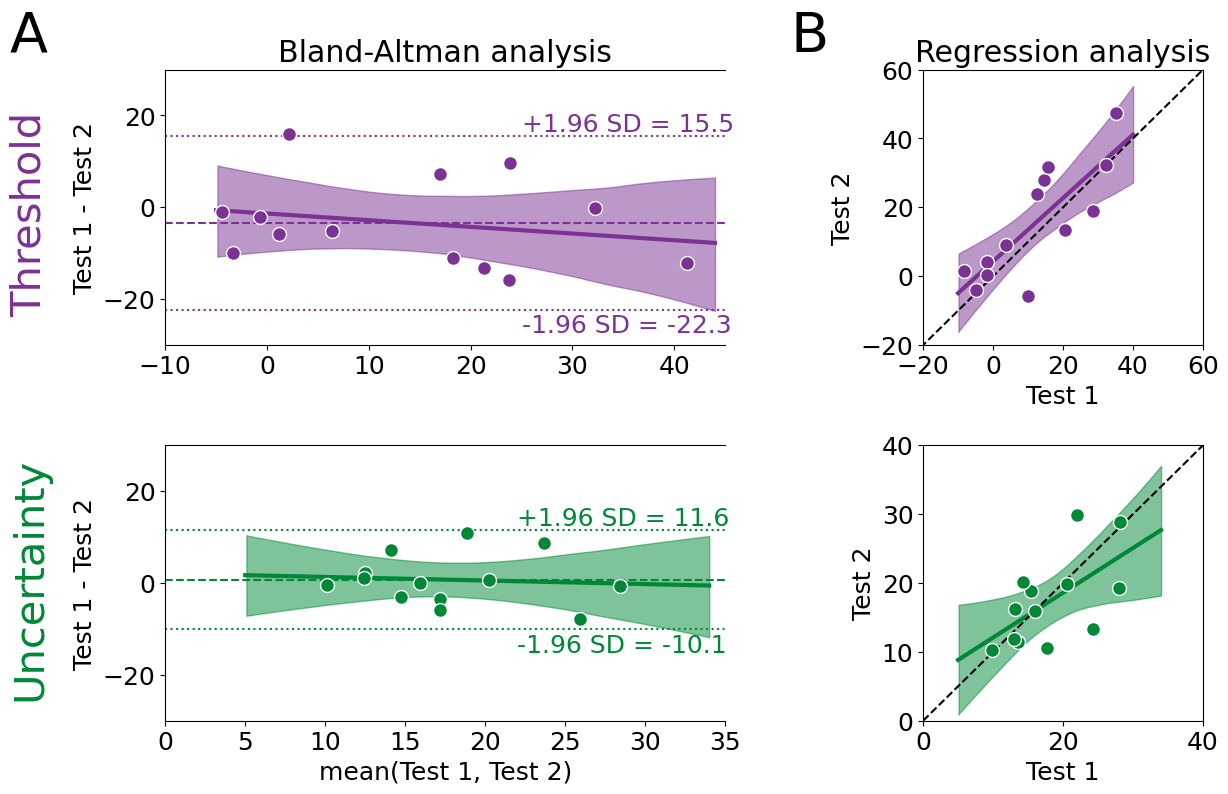

In [36]:
fig, ax = plt.subplots(2,2, figsize=(12,8), gridspec_kw={'width_ratios': [2, 1]},tight_layout=True)
x_a = np.arange(-10,71)
x_b = np.arange(0,51)

#Alpha bland-altman
az.plot_hdi(x_adiff_regress, mu_hat_adiff_regress.T, color=color_a, ax=ax[0,0], hdi_prob=0.95)
ax[0,0].plot(x_adiff_regress, np.mean(mu_hat_adiff_regress, axis=1), c=color_a, lw=3)
ax[0,0].plot(x_a,np.ones(81)*a_bias_summary["mean"][0],'--', color=color_a)
# ax[0,0].text(45, a_bias_summary["mean"][0]+1, 'Mean [95% HDI]', color=color_a)
# ax[0,0].text(45, a_bias_summary["mean"][0]-5, ' = ' + str(round(a_bias_summary["mean"][0])) + ' [' +
#              str(round(a_bias_summary["hdi_2.5%"][0])) + ' ' + str(round(a_bias_summary["hdi_97.5%"][0])) + ']',
#             color=color_a)
ax[0,0].plot(x_a, np.ones(81)*uplimit_alpha,color=color_a, ls=':')
ax[0,0].text(25, uplimit_alpha+1, '+1.96 SD = ' +str(round(uplimit_alpha,1)) + '         ', color=color_a)
ax[0,0].plot(x_a, np.ones(81)*lolimit_alpha,color=color_a, ls=':')
ax[0,0].text(25, lolimit_alpha-5, '-1.96 SD = ' +str(round(lolimit_alpha,1)), color=color_a)
ax[0,0].plot(alpha_mean,alpha_diff, 'o', c=color_a, ms=10, mec='w')
ax[0,0].set(ylabel='Test 1 - Test 2', xlim=(-10, 45), ylim=(-30,30), title='Bland-Altman analysis')
right_side = ax[0,0].spines["right"]
right_side.set_visible(False)
ax[0,0].patch.set_alpha(0)

#Beta Bland-altman
az.plot_hdi(x_bdiff_regress, mu_hat_bdiff_regress.T, color=color_b, ax=ax[1,0], hdi_prob=0.95)
ax[1,0].plot(x_bdiff_regress, np.mean(mu_hat_bdiff_regress, axis=1), c=color_b, lw=3)
ax[1,0].plot(x_b, np.ones(51)*uplimit_beta,color=color_b, ls=':')
ax[1,0].text(22, uplimit_beta+1, '+1.96 SD = ' +str(round(uplimit_beta,1)), color=color_b)
ax[1,0].plot(x_b, np.ones(51)*lolimit_beta,color=color_b, ls=':')
ax[1,0].text(22, lolimit_beta-5, '-1.96 SD = ' +str(round(lolimit_beta,1)), color=color_b)
ax[1,0].plot(x_b,np.ones(51)*b_bias_summary["mean"][0],'--', color=color_b)
ax[1,0].plot(beta_mean,beta_diff, 'o', c=color_b, ms=10, mec='w')
# ax[1,0].text(35, b_bias_summary["mean"][0]+1, 'Mean [95% HDI]', color=color_b)
# ax[1,0].text(35, b_bias_summary["mean"][0]-5, ' = ' + str(round(b_bias_summary["mean"][0])) + ' [' +
#              str(round(b_bias_summary["hdi_2.5%"][0])) + ' ' + str(round(b_bias_summary["hdi_97.5%"][0])) + ']',
#             color=color_b)
ax[1,0].set(xlabel='mean(Test 1, Test 2)', ylabel='Test 1 - Test 2', xlim=(0, 35), ylim=(-30,30))
right_side = ax[1,0].spines["right"]
right_side.set_visible(False)
ax[1,0].patch.set_alpha(0)

#Alpha regression
az.plot_hdi(x_aregress, mu_hat_alpha_regress.T, color=color_a, ax=ax[0,1], hdi_prob=0.95)
ax[0,1].plot(x_aregress, np.mean(mu_hat_alpha_regress, axis=1), c=color_a, lw=3)
ax[0,1].plot(np.arange(-50,61),np.arange(-50,61),'k--')
ax[0,1].plot(alphas[:,0],alphas[:,1], 'o', c=color_a, ms=10, mec='w')
ax[0,1].set(xlabel='Test 1', ylabel='Test 2', xlim=(-20,50), ylim=(-20,50), xticks=np.arange(-20,80,20), yticks=np.arange(-20,80,20), title='Regression analysis')
ax[0,1].patch.set_alpha(0)

#Beta regression
az.plot_hdi(x_bregress, mu_hat_beta_regress.T, color=color_b, ax=ax[1,1], hdi_prob=0.95)
ax[1,1].plot(x_bregress, np.mean(mu_hat_beta_regress, axis=1), c=color_b, lw=3)
ax[1,1].plot(np.arange(0,41),np.arange(0,41),'k--')
ax[1,1].plot(betas[:,0],betas[:,1], 'o', c=color_b, ms=10, mec='w')
ax[1,1].set(xlabel='Test 1', ylabel='Test 2', xlim=(0, 40), ylim=(0,40))
ax[1,1].patch.set_alpha(0)

#text
fig.text(-0.03, 0.63, 'Threshold', rotation='vertical', fontsize=30, c=color_a)
fig.text(-0.03, 0.15, 'Uncertainty', rotation='vertical', fontsize=30, c=color_b)

fig.text(-0.03, 0.95, 'A', fontsize=40, c='k')
fig.text(0.62, 0.95, 'B', fontsize=40, c='k')
fig.patch.set_alpha(0)

#Save
plt.savefig(fig_path + '/Results_Fig' + extension, transparent=True, bbox_inches='tight', pad_inches=1, edgecolor='w', dpi=1500)

# ICC (frequentist)

Calculcate the intraclass correlation coefficient ($ICC_{2,1}$) so we can compare to other studies. 

## Alpha

In [37]:
# Alpha
icc_a_df = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(alphas,len(alphas)*2)})
icc_alpha = pg.intraclass_corr(data=icc_a_df, targets='subj', raters='test', ratings='data')
icc_alpha.set_index('Type')
icc_alpha.loc[1]

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

Type                           ICC2
Description    Single random raters
ICC                        0.796358
F                          9.180985
df1                              12
df2                              12
pval                       0.000268
CI95%                  [0.48, 0.93]
Name: 1, dtype: object

## Beta

In [38]:
# Beta
icc_b_df = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(betas,len(betas)*2)})
icc_beta = pg.intraclass_corr(data=icc_b_df, targets='subj', raters='test', ratings='data')
icc_beta.set_index('Type')
icc_beta.loc[1]

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

Type                           ICC2
Description    Single random raters
ICC                        0.612006
F                          3.965313
df1                              12
df2                              12
pval                       0.012066
CI95%                  [0.11, 0.86]
Name: 1, dtype: object

# Agreement on 50 trials

Since we want the test to be efficient, we want to make sure that the alpha and beta estaimtes still have good agreement after 50 trials. 


In [39]:
#Load the data
unique_tests = ['a','b']
alphas_50, betas_50 = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(test[test.Test==test_id].loc[49])
        # # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas_50[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[49]+BslDiff
        betas_50[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[49]
        
#Calculate differences 
alpha_diff_50 = alphas_50[:,0] - alphas_50[:,1]
beta_diff_50 = betas_50[:,0] - betas_50[:,1]

alpha_mean_50 = np.mean(alphas_50,axis=1)
beta_mean_50 = np.mean(betas_50,axis=1)

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_57310/1120636937.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


In [40]:
#Run all the analyses 
#Mean bias

#Alpha
_, trace_abias_50, = bayes_onesamp_ttest(alpha_diff_50, prior=[0,20])
a_bias_summary_50 = az.summary(trace_abias_50, var_names=["mu", "sigma"], hdi_prob=0.95)
#Beta
_, trace_bbias_50 = bayes_onesamp_ttest(beta_diff_50, prior=[0,20])
b_bias_summary_50 = az.summary(trace_bbias_50, var_names=["mu", "sigma"], hdi_prob=0.95)

#Bias across true scores

#Alpha
trace_alpha_diff_regress_50, _ = bayes_simple_regression(alpha_diff_50, alpha_mean_50, intercept_prior=[0,5], slope_prior=[0,1])
alpha_regress_summary_50 = az.summary(trace_alpha_diff_regress_50, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)
#Beta
trace_beta_diff_regress_50, _ = bayes_simple_regression(beta_diff_50, beta_mean_50, intercept_prior=[0,5], slope_prior=[0,1])
beta_regress_summary_50 = az.summary(trace_beta_diff_regress_50, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)


#Limits of agreement

#Alpha
uplimit_alpha_50 = np.mean(alpha_diff_50) + 1.96*np.std(alpha_diff_50, ddof=1)
lolimit_alpha_50 = np.mean(alpha_diff_50) - 1.96*np.std(alpha_diff_50, ddof=1)
#Beta
uplimit_beta_50 = np.mean(beta_diff_50) + 1.96*np.std(beta_diff_50, ddof=1)
lolimit_beta_50 = np.mean(beta_diff_50) - 1.96*np.std(beta_diff_50, ddof=1)

#Regression 

#Alpha
trace_alpha_regress_50, _ = bayes_simple_regression(alphas_50[:,1], alphas_50[:,0], intercept_prior=[0,20], slope_prior=[1,2])
regress_summary_alpha_50 = az.summary(trace_alpha_regress_50, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)
#Beta
trace_beta_regress_50, _ = bayes_simple_regression(betas_50[:,1], betas_50[:,0], intercept_prior=[0,20], slope_prior=[1,2])
regress_summary_beta_50 = az.summary(trace_beta_regress_50, var_names=["intercept", "slope", "sigma"],hdi_prob=0.95)

#ICC

# Alpha
icc_a_df_50 = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(alphas_50,len(alphas_50)*2)})
icc_alpha_50 = pg.intraclass_corr(data=icc_a_df_50, targets='subj', raters='test', ratings='data')
# Beta
icc_b_df_50 = pd.DataFrame({'subj': [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13], 
                      'test':['A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B','A','B'],
                       'data': np.reshape(betas_50,len(betas_50)*2)})
icc_beta_50 = pg.intraclass_corr(data=icc_b_df_50, targets='subj', raters='test', ratings='data')

Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 23 seconds.
Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 23 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 29 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 31 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.
Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 35 seconds.
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-in

In [41]:
# make a table
headers = ["Limits of agreement", "Bland-Altman mean bias", "Bland-Altman bias regression", "Test 1 vs Test 2 regression", "ICC [2,1]"]
headers
row1 = ["Threshold (alpha)", " ", " ", " ", " ", " "]
row2 = ["50 Trials", 
        str(round(lolimit_alpha_50,1)) + ' to ' + str(round(uplimit_alpha_50,1)), 
        str(round(a_bias_summary_50["mean"][0],1)) + ' [' + str(round(a_bias_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(a_bias_summary_50["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(alpha_regress_summary_50["mean"][1],2)) + ' [' + str(round(alpha_regress_summary_50["hdi_2.5%"][1],2)) + ' ' + str(round(alpha_regress_summary_50["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_alpha_50["mean"][1],2)) + ' [' + str(round(regress_summary_alpha_50["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_alpha_50["hdi_97.5%"][1],2)) + ']',
        str(round(icc_alpha_50.loc[1][2],2)) + ' ' + str(icc_alpha_50["CI95%"][1])]
row3 = [" ", " ", " ", 
        'Intercept = ' + str(round(alpha_regress_summary_50["mean"][0],1)) + ' [' + str(round(alpha_regress_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(alpha_regress_summary_50["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_alpha_50["mean"][0],1)) + ' [' + str(round(regress_summary_alpha_50["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_alpha_50["hdi_97.5%"][0],1)) + ']',]
row4 = ["75 Trials", 
        str(round(lolimit_alpha,1)) + ' to ' + str(round(uplimit_alpha,1)),
        str(round(a_bias_summary["mean"][0],1)) + ' [' + str(round(a_bias_summary["hdi_2.5%"][0],1)) + ' ' + str(round(a_bias_summary["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(alpha_regress_summary["mean"][1],2)) + ' [' + str(round(alpha_regress_summary["hdi_2.5%"][1],2)) + ' ' + str(round(alpha_regress_summary["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_alpha["mean"][1],2)) + ' [' + str(round(regress_summary_alpha["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_alpha["hdi_97.5%"][1],2)) + ']',
        str(round(icc_alpha.loc[1][2],2)) + ' ' + str(icc_alpha["CI95%"][1])]
row5 = [" ", " ", " ", 
        'Intercept = ' + str(round(alpha_regress_summary["mean"][0],1)) + ' [' + str(round(alpha_regress_summary["hdi_2.5%"][0],1)) + ' ' + str(round(alpha_regress_summary["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_alpha["mean"][0],1)) + ' [' + str(round(regress_summary_alpha["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_alpha["hdi_97.5%"][0],1)) + ']']
row6 = ["Uncertainty (beta)", " ", " ", " ", " ", " "]
row7 = ["50 Trials", 
        str(round(lolimit_beta_50,1)) + ' to ' + str(round(uplimit_beta_50,1)),
        str(round(b_bias_summary_50["mean"][0],1)) + ' [' + str(round(b_bias_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(b_bias_summary_50["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(beta_regress_summary_50["mean"][1],2)) + ' [' + str(round(beta_regress_summary_50["hdi_2.5%"][1],2)) + ' ' + str(round(beta_regress_summary_50["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_beta_50["mean"][1],2)) + ' [' + str(round(regress_summary_beta_50["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_beta_50["hdi_97.5%"][1],2)) + ']',
        str(round(icc_beta_50.loc[1][2],2)) + ' ' + str(icc_beta_50["CI95%"][1])]
row8 = [" ", " ", " "," "
        'Intercept = ' + str(round(beta_regress_summary_50["mean"][0],1)) + ' [' + str(round(beta_regress_summary_50["hdi_2.5%"][0],1)) + ' ' + str(round(beta_regress_summary_50["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_beta_50["mean"][0],1)) + ' [' + str(round(regress_summary_beta_50["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_beta_50["hdi_97.5%"][0],1)) + ']',]
row9 = ["75 Trials", 
        str(round(lolimit_beta,1)) + ' to ' + str(round(uplimit_beta,1)),
        str(round(b_bias_summary["mean"][0],1)) + ' [' + str(round(b_bias_summary["hdi_2.5%"][0],1)) + ' ' + str(round(b_bias_summary["hdi_97.5%"][0],1)) + ']',
        'Slope = ' + str(round(beta_regress_summary["mean"][1],2)) + ' [' + str(round(beta_regress_summary["hdi_2.5%"][1],2)) + ' ' + str(round(beta_regress_summary["hdi_97.5%"][1],2)) + ']',
        'Slope = ' + str(round(regress_summary_beta["mean"][1],2)) + ' [' + str(round(regress_summary_beta["hdi_2.5%"][1],2)) + ' ' + str(round(regress_summary_beta["hdi_97.5%"][1],2)) + ']',
        str(round(icc_beta.loc[1][2],2)) + ' ' + str(icc_beta_50["CI95%"][1])]
row10 = [" ", " ", " ", 
        'Intercept = ' + str(round(beta_regress_summary["mean"][0],1)) + ' [' + str(round(beta_regress_summary["hdi_2.5%"][0],1)) + ' ' + str(round(beta_regress_summary["hdi_97.5%"][0],1)) + ']',
        'Intercept = ' + str(round(regress_summary_beta["mean"][0],1)) + ' [' + str(round(regress_summary_beta["hdi_2.5%"][0],1)) + ' ' + str(round(regress_summary_beta["hdi_97.5%"][0],1)) + ']',]
table = [row1, row2, row3, row4, row5, row6, row7, row8, row9, row10]
print(tabulate(table, headers=headers))

                    Limits of agreement    Bland-Altman mean bias    Bland-Altman bias regression    Test 1 vs Test 2 regression    ICC [2,1]
------------------  ---------------------  ------------------------  ------------------------------  -----------------------------  ----------------
Threshold (alpha)
50 Trials           -22.3 to 15.7          -3.2 [-9.1 2.8]           Slope = -0.18 [-0.58 0.21]      Slope = 0.93 [0.46 1.4]        0.78 [0.43 0.92]
                                                                     Intercept = -0.8 [-7.0 5.2]     Intercept = 3.9 [-4.0 11.8]
75 Trials           -22.3 to 15.5          -3.3 [-8.9 2.8]           Slope = -0.14 [-0.57 0.28]      Slope = 0.92 [0.48 1.36]       0.8 [0.48 0.93]
                                                                     Intercept = -1.4 [-9.4 7.2]     Intercept = 4.3 [-3.8 12.2]
Uncertainty (beta)
50 Trials           -9.3 to 10.2           0.5 [-2.6 3.6]            Slope = 0.02 [-0.39 0.45]       Slope = 0.59 [0.

# Discussion analyses

## Footedness 

In [42]:
#Load the data
Demo = pd.read_csv('/Users/jonathanwood/Documents/GitHub/Split-Belt-AFC-Reliability/Data/TRT_psi_notebook.csv')

#index footedness values and alpha values
waterloo = Demo.Waterloo.values
all_alphas = np.array([Demo.Alpha_T1.values, Demo.Alpha_T2.values])
y_alpha = np.mean(all_alphas,axis=0)

trace_foot, _ = bayes_simple_regression(y_data=y_alpha, x_data=waterloo, intercept_prior=[0, 20], slope_prior=[0,2])
az.summary(trace_foot,  var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)

Sampling: [intercept, sigma, slope, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   8.264  4.073     0.319     16.475      0.028    0.020   21716.0   
slope       0.050  0.050    -0.049      0.147      0.000    0.000   22287.0   
sigma      14.918  2.431    10.650     19.781      0.016    0.012   22806.0   

           ess_tail  r_hat  
intercept   22755.0    1.0  
slope       23769.0    1.0  
sigma       21870.0    1.0

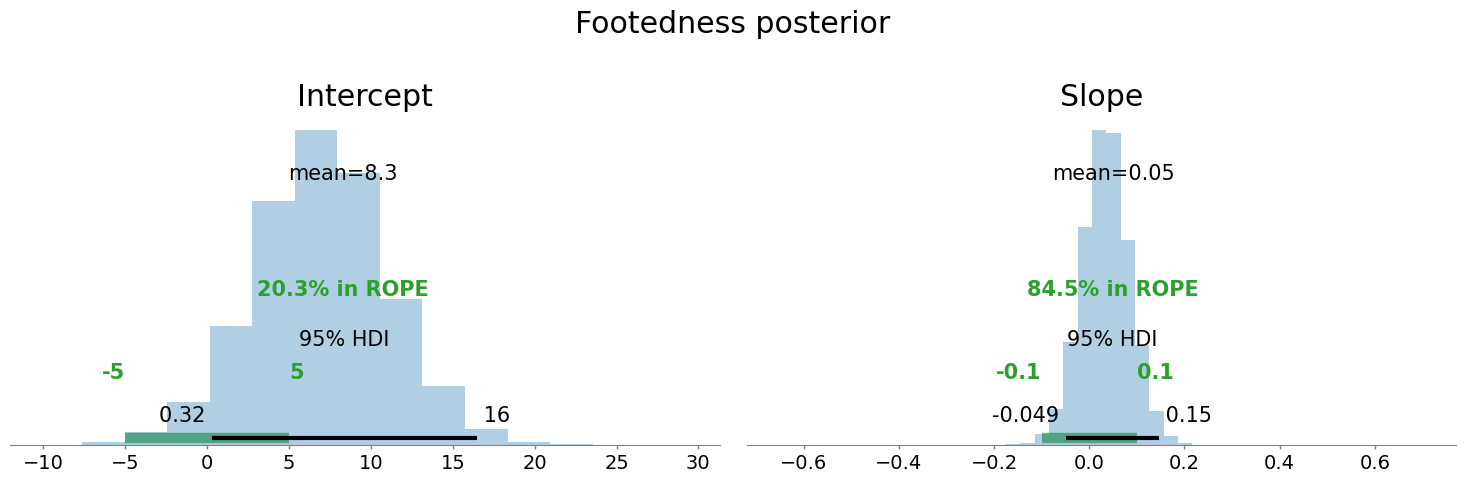

In [43]:
#Extract posterior
posterior_foot = az.extract(trace_foot.posterior)

#Define ROPE
rope_intercept_foot = 5
rope_slope_foot = 0.1

#Plot alpha
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)
az.plot_posterior(posterior_foot.intercept.values,kind='hist', rope=(-rope_intercept_foot,rope_intercept_foot), hdi_prob=0.95, ax=ax[0])
ax[0].set(title='Intercept')
az.plot_posterior(posterior_foot.slope.values,kind='hist',  rope=(-rope_slope_foot, rope_slope_foot), hdi_prob=0.95, ax=ax[1])
ax[1].set(title='Slope')
plt.suptitle('Footedness posterior')
plt.show()

/Users/jonathanwood/opt/anaconda3/envs/psi_reliability_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


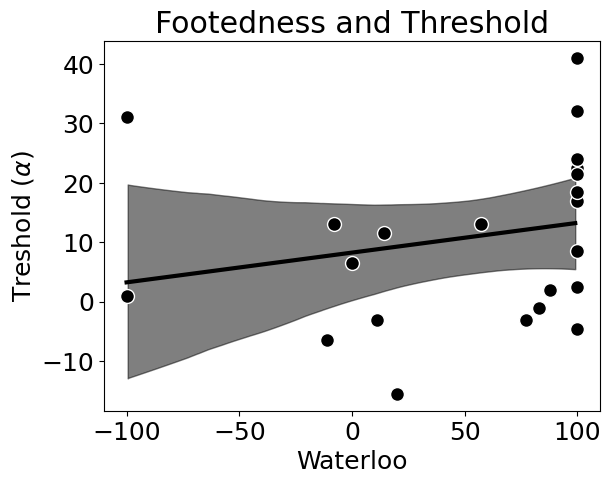

In [44]:
#Posterior plotted against data
#Prep
x_foot = np.arange(-100, 100)
mu_hat_foot_regress = np.zeros((len(x_foot), len(posterior_foot.intercept.values)))
for i, x in enumerate(x_foot):
    mu_hat_foot_regress[i] = posterior_foot.intercept.values + posterior_foot.slope.values*x

#Plot
fig, ax = plt.subplots()
az.plot_hdi(x_foot, mu_hat_foot_regress.T, color='k', ax=ax, hdi_prob=0.95)
ax.plot(x_foot, np.mean(mu_hat_foot_regress, axis=1), c='k', lw=3)
ax.plot(waterloo,y_alpha, 'o', c='k', ms=10, mec='w')
ax.set(title='Footedness and Threshold', xlabel='Waterloo', ylabel=r'Treshold ($\alpha$)')
plt.show()

## Pilot data for test limb and threshold bias

Does it matter which limb was the test limb? Since we randomized the test limb in our pilot data, I am going to see if this had an impact on the threshold ($\alpha$) values. 

Here I am modeling the threshold values as two seperate normal distributions. I made the priors for them the same because I have no a priori reason to think that the test limb woulkd make the threshold estiamtes come from seperate distirbutions. I am making the prior distribution pretty uninformative too. As for the ROPE, since there is naturally more variability within subjects compared to between, I am making the ROPE between -20 and 20mm of difference since this is practically equivilant for our purposes. 

In [45]:
#Organize the data
pilot_ref = Demo.Reference_Leg.values[:10]
pilot_alpha = y_alpha[:10]
alpha_left = pilot_alpha[pilot_ref=='Left']
alpha_right = pilot_alpha[pilot_ref=='Right']

#Calculate the posterior
with pm.Model() as Model_TestLimb:
    mu_left = pm.Normal("mu_left", mu=0, sigma=50)
    sigma_left = pm.Exponential("sigma_left", 0.01)
    mu_right = pm.Normal("mu_right", mu=0, sigma=50)
    sigma_right = pm.Exponential("sigma_right", 0.01)
    y_left = pm.Normal("y_left",mu=mu_left, sigma=sigma_left, observed=alpha_left)
    y_right = pm.Normal("y_right",mu=mu_right, sigma=sigma_right, observed=alpha_right)
    trace_TestLimb = pm.sample(draws=10000, tune=2000, chains=4, cores=4)
az.summary(trace_TestLimb, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_left, sigma_left, mu_right, sigma_right]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 28 seconds.


mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mu_left      11.513   2.572     6.346     16.390      0.029    0.021   
mu_right      4.855  10.305   -15.510     25.900      0.089    0.073   
sigma_left    4.184   4.088     1.001     10.419      0.046    0.032   
sigma_right  23.656  10.646    10.048     43.751      0.094    0.072   

             ess_bulk  ess_tail  r_hat  
mu_left       12087.0    8733.0    1.0  
mu_right      15060.0   13787.0    1.0  
sigma_left    10577.0   10430.0    1.0  
sigma_right   16606.0   15282.0    1.0

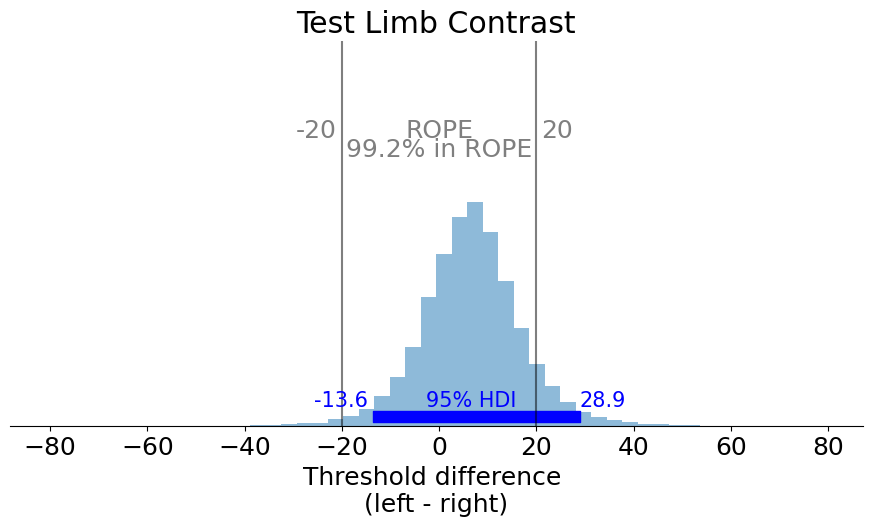

In [46]:
#extract posterior
posterior_TestLimb = az.extract(trace_TestLimb.posterior)

#Calculate left - right contrast
contrast_TestLimb = posterior_TestLimb.mu_left.values - posterior_TestLimb.mu_right.values
hdi_95_contrast_TL = az.hdi(contrast_TestLimb, hdi_prob=0.95)

#Define ROPE
test_limb_rope = 20
prctinrope_testlimb = (np.sum((contrast_TestLimb>-test_limb_rope) & (contrast_TestLimb<test_limb_rope)) / len(contrast_TestLimb))*100

#Plot
fig, ax = plt.subplots(figsize=(11,5))
ax.vlines([-test_limb_rope, test_limb_rope], ymin=[0,0], ymax=[10000,10000], color='k', alpha=0.5)
ax.hist(contrast_TestLimb, 50, alpha=0.5)
ax.text(0, 7500, 'ROPE', ha='center', alpha=0.5)
ax.text(0, 7000, str(round(prct_in_rope,1)) + '% in ROPE', ha='center', alpha=0.5)
ax.text(-test_limb_rope-1, 7500, '-' + str(test_limb_rope), ha='right', alpha=0.5)
ax.text(test_limb_rope+1, 7500, str(test_limb_rope), ha='left', alpha=0.5)
ax.fill_between(hdi_95_contrast_TL, y1=np.zeros_like(hdi_95_contrast_TL)+100, y2=np.zeros_like(hdi_95_contrast_TL)+400, color='b')
ax.text(np.mean(contrast_TestLimb),500, '95% HDI', ha='center', color='b', size=15)
ax.text(hdi_95_contrast_TL[0]-1, 500, str(np.round(hdi_95_contrast_TL[0],1)), ha='right', size=15, color='b')
ax.text(hdi_95_contrast_TL[1]+0.01, 500, str(np.round(hdi_95_contrast_TL[1],1)), ha='left', size=15, color='b')
ax.set(title='Test Limb Contrast', xlabel='Threshold difference \n' + '(left - right)', yticks=[], ylim=(0,10000))
top_side = ax.spines["top"]
top_side.set_visible(False)
right_side = ax.spines["right"]
right_side.set_visible(False)
left_side = ax.spines["left"]
left_side.set_visible(False)
plt.show()

## IQR for comparison to Jones et al., 2010

Since I dont calculcate the IQR (middle 50%) of the distribution, I wanted to calculcate it here in order to compare to other studies

In [47]:
# Calculcate middle 50% to compare to other studies 
x = np.arange(-100,100.001,0.001)

unique_tests = ['a','b']
#Extract the final estimates of the alpha and beta values
iqr = np.empty((len(grp_subjs),2))
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        a = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        b = test[test.Test==test_id].Beta_EV.values[-1]
        
        psi = norm.cdf(x,a,b)

        prct_25_idx = np.argmin(np.abs(psi-0.25))
        prct_75_idx = np.argmin(np.abs(psi-0.75))
        iqr[subj_name_idx, test_id_idx] = x[prct_75_idx] - x[prct_25_idx]
        
#Display
print('All = ' + str(round(np.mean(iqr),1)) + ' +/- ' + str(round(np.std(iqr),1)))
print('Test 1 IQR = ' + str(round(np.mean(iqr[:,0]),1)) + ' +/- ' + str(round(np.std(iqr[:,0]),1)))
print('Test 2 IQR = ' + str(round(np.mean(iqr[:,1]),1)) + ' +/- ' + str(round(np.std(iqr[:,1]),1)))

All = 24.0 +/- 8.0
Test 1 IQR = 24.5 +/- 7.7
Test 2 IQR = 23.5 +/- 8.3


/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_57310/1402546052.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for subj_name_idx, (name, test) in enumerate(grp_subjs):


## Minimal detectable change

Since we will eventually use this for a pre post-test comparison, it would be good to have a sense of the minimal detectable change. I calculcated the MDC for this sample here according to a formula from Portney and Watkins 2009. 

In [48]:
#Calcualte minimal detectable change as the standard error of measurement = SD of scores * sqrt(1-reliability)
mdc_alpha_75 = np.std(alphas[:,0],ddof=1) * np.sqrt(1-icc_alpha.loc[1][2])
mdc_alpha_50 = np.std(alphas_50[:,0],ddof=1) * np.sqrt(1-icc_alpha_50.loc[1][2])
mdc_beta_75 = np.std(betas[:,0],ddof=1) * np.sqrt(1-icc_beta.loc[1][2])
mdc_beta_50 = np.std(betas_50[:,0],ddof=1) * np.sqrt(1-icc_beta_50.loc[1][2])

print('MDC alpha after 75 trials: ' + str(round(mdc_alpha_75,2)))
print('MDC alpha after 50 trials: ' + str(round(mdc_alpha_50,2)))
print('MDC beta after 75 trials: ' + str(round(mdc_beta_75,2)))
print('MDC beta after 50 trials: ' + str(round(mdc_beta_50,2)))

MDC alpha after 75 trials: 6.47
MDC alpha after 50 trials: 6.41
MDC beta after 75 trials: 3.71
MDC beta after 50 trials: 3.49
